In [4]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [5]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-08-28 11:38:19.216614: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loading the data

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

   16384/11490434 [..............................] - ETA: 0s

 8691712/11490434 [=====================>........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


11501568/11490434 [==============================] - 0s 0us/step


Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [7]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [8]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


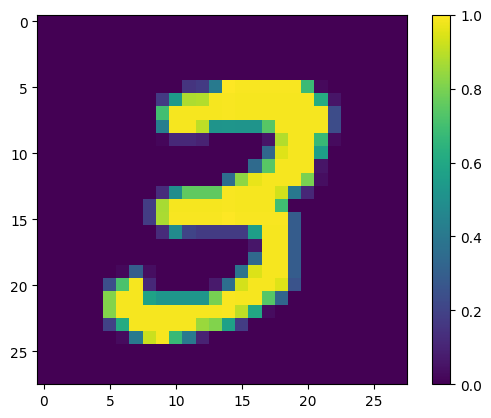

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

downscaling and feature engineering

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


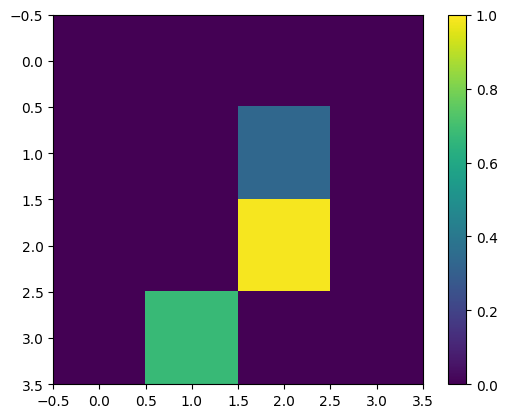

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [13]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [14]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [15]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [16]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


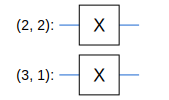

In [17]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [18]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [19]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

Quantum neural network

In [20]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


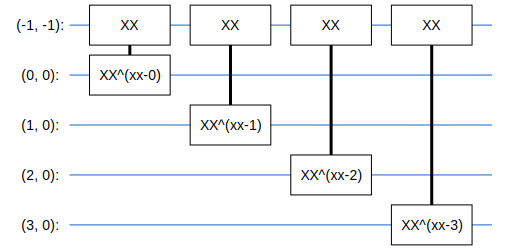

In [21]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [22]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [23]:
model_circuit, model_readout = create_quantum_model()

In [24]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [25]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [26]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [27]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [28]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


T

In [29]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [30]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [31]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


  1/324 [..............................] - ETA: 4:03 - loss: 1.0036 - hinge_accuracy: 0.4688

  2/324 [..............................] - ETA: 1:02 - loss: 1.0006 - hinge_accuracy: 0.5156

  3/324 [..............................] - ETA: 1:00 - loss: 0.9981 - hinge_accuracy: 0.5521

  4/324 [..............................] - ETA: 1:00 - loss: 1.0026 - hinge_accuracy: 0.5234

  5/324 [..............................] - ETA: 1:00 - loss: 1.0011 - hinge_accuracy: 0.5500

  6/324 [..............................] - ETA: 59s - loss: 0.9993 - hinge_accuracy: 0.5625 

  7/324 [..............................] - ETA: 59s - loss: 1.0013 - hinge_accuracy: 0.5491

  8/324 [..............................] - ETA: 59s - loss: 1.0008 - hinge_accuracy: 0.5508

  9/324 [..............................] - ETA: 59s - loss: 0.9990 - hinge_accuracy: 0.5729

 10/324 [..............................] - ETA: 59s - loss: 1.0000 - hinge_accuracy: 0.5688

 11/324 [>.............................] - ETA: 58s - loss: 1.0000 - hinge_accuracy: 0.5625

 12/324 [>.............................] - ETA: 58s - loss: 1.0006 - hinge_accuracy: 0.5573

 13/324 [>.............................] - ETA: 58s - loss: 0.9998 - hinge_accuracy: 0.5625

 14/324 [>.............................] - ETA: 58s - loss: 0.9995 - hinge_accuracy: 0.5603

 15/324 [>.............................] - ETA: 58s - loss: 0.9978 - hinge_accuracy: 0.5708

 16/324 [>.............................] - ETA: 57s - loss: 0.9972 - hinge_accuracy: 0.5762

 17/324 [>.............................] - ETA: 57s - loss: 0.9972 - hinge_accuracy: 0.5699

 18/324 [>.............................] - ETA: 57s - loss: 0.9976 - hinge_accuracy: 0.5642

 19/324 [>.............................] - ETA: 57s - loss: 0.9976 - hinge_accuracy: 0.5592

 20/324 [>.............................] - ETA: 57s - loss: 0.9974 - hinge_accuracy: 0.5562

 21/324 [>.............................] - ETA: 57s - loss: 0.9974 - hinge_accuracy: 0.5551

 22/324 [=>............................] - ETA: 56s - loss: 0.9978 - hinge_accuracy: 0.5483

 23/324 [=>............................] - ETA: 56s - loss: 0.9977 - hinge_accuracy: 0.5476

 24/324 [=>............................] - ETA: 56s - loss: 0.9977 - hinge_accuracy: 0.5443

 25/324 [=>............................] - ETA: 56s - loss: 0.9978 - hinge_accuracy: 0.5412

 26/324 [=>............................] - ETA: 56s - loss: 0.9971 - hinge_accuracy: 0.5469

 27/324 [=>............................] - ETA: 55s - loss: 0.9971 - hinge_accuracy: 0.5451

 28/324 [=>............................] - ETA: 55s - loss: 0.9976 - hinge_accuracy: 0.5379

 29/324 [=>............................] - ETA: 55s - loss: 0.9979 - hinge_accuracy: 0.5323

 30/324 [=>............................] - ETA: 55s - loss: 0.9980 - hinge_accuracy: 0.5292

 31/324 [=>............................] - ETA: 55s - loss: 0.9979 - hinge_accuracy: 0.5292

 32/324 [=>............................] - ETA: 55s - loss: 0.9975 - hinge_accuracy: 0.5312

 33/324 [==>...........................] - ETA: 54s - loss: 0.9972 - hinge_accuracy: 0.5303

 34/324 [==>...........................] - ETA: 54s - loss: 0.9979 - hinge_accuracy: 0.5239

 35/324 [==>...........................] - ETA: 54s - loss: 0.9981 - hinge_accuracy: 0.5205

 36/324 [==>...........................] - ETA: 54s - loss: 0.9984 - hinge_accuracy: 0.5174

 37/324 [==>...........................] - ETA: 54s - loss: 0.9980 - hinge_accuracy: 0.5194

 38/324 [==>...........................] - ETA: 54s - loss: 0.9980 - hinge_accuracy: 0.5181

 39/324 [==>...........................] - ETA: 53s - loss: 0.9980 - hinge_accuracy: 0.5168

 40/324 [==>...........................] - ETA: 53s - loss: 0.9980 - hinge_accuracy: 0.5172

 41/324 [==>...........................] - ETA: 53s - loss: 0.9982 - hinge_accuracy: 0.5160

 42/324 [==>...........................] - ETA: 53s - loss: 0.9982 - hinge_accuracy: 0.5141

 43/324 [==>...........................] - ETA: 53s - loss: 0.9982 - hinge_accuracy: 0.5160

 44/324 [===>..........................] - ETA: 52s - loss: 0.9983 - hinge_accuracy: 0.5156

 45/324 [===>..........................] - ETA: 52s - loss: 0.9990 - hinge_accuracy: 0.5104

 46/324 [===>..........................] - ETA: 52s - loss: 0.9994 - hinge_accuracy: 0.5075

 47/324 [===>..........................] - ETA: 52s - loss: 0.9992 - hinge_accuracy: 0.5093

 48/324 [===>..........................] - ETA: 52s - loss: 0.9988 - hinge_accuracy: 0.5137

 49/324 [===>..........................] - ETA: 51s - loss: 0.9989 - hinge_accuracy: 0.5128

 50/324 [===>..........................] - ETA: 51s - loss: 0.9991 - hinge_accuracy: 0.5113

 51/324 [===>..........................] - ETA: 51s - loss: 0.9993 - hinge_accuracy: 0.5086

 52/324 [===>..........................] - ETA: 51s - loss: 0.9993 - hinge_accuracy: 0.5090

 53/324 [===>..........................] - ETA: 51s - loss: 0.9995 - hinge_accuracy: 0.5071

 54/324 [====>.........................] - ETA: 50s - loss: 0.9992 - hinge_accuracy: 0.5098

 55/324 [====>.........................] - ETA: 50s - loss: 0.9991 - hinge_accuracy: 0.5108

 56/324 [====>.........................] - ETA: 50s - loss: 0.9989 - hinge_accuracy: 0.5117

 57/324 [====>.........................] - ETA: 50s - loss: 0.9990 - hinge_accuracy: 0.5115

 58/324 [====>.........................] - ETA: 50s - loss: 0.9989 - hinge_accuracy: 0.5119

 59/324 [====>.........................] - ETA: 49s - loss: 0.9989 - hinge_accuracy: 0.5122

 60/324 [====>.........................] - ETA: 49s - loss: 0.9988 - hinge_accuracy: 0.5130

 61/324 [====>.........................] - ETA: 49s - loss: 0.9989 - hinge_accuracy: 0.5118

 62/324 [====>.........................] - ETA: 49s - loss: 0.9986 - hinge_accuracy: 0.5131

 63/324 [====>.........................] - ETA: 49s - loss: 0.9985 - hinge_accuracy: 0.5134

 64/324 [====>.........................] - ETA: 49s - loss: 0.9982 - hinge_accuracy: 0.5171

 65/324 [=====>........................] - ETA: 48s - loss: 0.9983 - hinge_accuracy: 0.5168

 66/324 [=====>........................] - ETA: 48s - loss: 0.9980 - hinge_accuracy: 0.5185

 67/324 [=====>........................] - ETA: 48s - loss: 0.9978 - hinge_accuracy: 0.5201

 68/324 [=====>........................] - ETA: 48s - loss: 0.9977 - hinge_accuracy: 0.5211

 69/324 [=====>........................] - ETA: 48s - loss: 0.9977 - hinge_accuracy: 0.5213

 70/324 [=====>........................] - ETA: 47s - loss: 0.9975 - hinge_accuracy: 0.5228

 71/324 [=====>........................] - ETA: 47s - loss: 0.9975 - hinge_accuracy: 0.5229

 72/324 [=====>........................] - ETA: 47s - loss: 0.9977 - hinge_accuracy: 0.5208

 73/324 [=====>........................] - ETA: 47s - loss: 0.9979 - hinge_accuracy: 0.5197

 74/324 [=====>........................] - ETA: 47s - loss: 0.9976 - hinge_accuracy: 0.5215

 75/324 [=====>........................] - ETA: 46s - loss: 0.9977 - hinge_accuracy: 0.5217

 76/324 [======>.......................] - ETA: 46s - loss: 0.9976 - hinge_accuracy: 0.5222

 77/324 [======>.......................] - ETA: 46s - loss: 0.9974 - hinge_accuracy: 0.5227

 78/324 [======>.......................] - ETA: 46s - loss: 0.9972 - hinge_accuracy: 0.5244

 79/324 [======>.......................] - ETA: 46s - loss: 0.9971 - hinge_accuracy: 0.5249

 80/324 [======>.......................] - ETA: 46s - loss: 0.9969 - hinge_accuracy: 0.5266

 81/324 [======>.......................] - ETA: 45s - loss: 0.9966 - hinge_accuracy: 0.5289

 82/324 [======>.......................] - ETA: 45s - loss: 0.9966 - hinge_accuracy: 0.5290

 83/324 [======>.......................] - ETA: 45s - loss: 0.9966 - hinge_accuracy: 0.5290

 84/324 [======>.......................] - ETA: 45s - loss: 0.9966 - hinge_accuracy: 0.5290

 85/324 [======>.......................] - ETA: 45s - loss: 0.9965 - hinge_accuracy: 0.5298

 86/324 [======>.......................] - ETA: 44s - loss: 0.9963 - hinge_accuracy: 0.5298

 87/324 [=======>......................] - ETA: 44s - loss: 0.9966 - hinge_accuracy: 0.5269

 88/324 [=======>......................] - ETA: 44s - loss: 0.9963 - hinge_accuracy: 0.5288

 89/324 [=======>......................] - ETA: 44s - loss: 0.9962 - hinge_accuracy: 0.5288

 90/324 [=======>......................] - ETA: 44s - loss: 0.9960 - hinge_accuracy: 0.5295

 91/324 [=======>......................] - ETA: 43s - loss: 0.9959 - hinge_accuracy: 0.5295

 92/324 [=======>......................] - ETA: 43s - loss: 0.9957 - hinge_accuracy: 0.5302

 93/324 [=======>......................] - ETA: 43s - loss: 0.9954 - hinge_accuracy: 0.5316

 94/324 [=======>......................] - ETA: 43s - loss: 0.9952 - hinge_accuracy: 0.5329

 95/324 [=======>......................] - ETA: 43s - loss: 0.9951 - hinge_accuracy: 0.5329

 96/324 [=======>......................] - ETA: 43s - loss: 0.9948 - hinge_accuracy: 0.5352

 97/324 [=======>......................] - ETA: 42s - loss: 0.9948 - hinge_accuracy: 0.5345

 98/324 [========>.....................] - ETA: 42s - loss: 0.9951 - hinge_accuracy: 0.5322

 99/324 [========>.....................] - ETA: 42s - loss: 0.9951 - hinge_accuracy: 0.5322

100/324 [========>.....................] - ETA: 42s - loss: 0.9949 - hinge_accuracy: 0.5325

101/324 [========>.....................] - ETA: 42s - loss: 0.9947 - hinge_accuracy: 0.5328

102/324 [========>.....................] - ETA: 41s - loss: 0.9943 - hinge_accuracy: 0.5337

103/324 [========>.....................] - ETA: 41s - loss: 0.9941 - hinge_accuracy: 0.5340

104/324 [========>.....................] - ETA: 41s - loss: 0.9940 - hinge_accuracy: 0.5343

105/324 [========>.....................] - ETA: 41s - loss: 0.9939 - hinge_accuracy: 0.5351

106/324 [========>.....................] - ETA: 41s - loss: 0.9937 - hinge_accuracy: 0.5357

107/324 [========>.....................] - ETA: 40s - loss: 0.9935 - hinge_accuracy: 0.5359

108/324 [=========>....................] - ETA: 40s - loss: 0.9938 - hinge_accuracy: 0.5350

109/324 [=========>....................] - ETA: 40s - loss: 0.9938 - hinge_accuracy: 0.5344

110/324 [=========>....................] - ETA: 40s - loss: 0.9938 - hinge_accuracy: 0.5347

111/324 [=========>....................] - ETA: 40s - loss: 0.9937 - hinge_accuracy: 0.5338

112/324 [=========>....................] - ETA: 39s - loss: 0.9935 - hinge_accuracy: 0.5338

113/324 [=========>....................] - ETA: 39s - loss: 0.9933 - hinge_accuracy: 0.5337

114/324 [=========>....................] - ETA: 39s - loss: 0.9930 - hinge_accuracy: 0.5348

115/324 [=========>....................] - ETA: 39s - loss: 0.9928 - hinge_accuracy: 0.5353

116/324 [=========>....................] - ETA: 39s - loss: 0.9930 - hinge_accuracy: 0.5339

117/324 [=========>....................] - ETA: 39s - loss: 0.9929 - hinge_accuracy: 0.5342

118/324 [=========>....................] - ETA: 38s - loss: 0.9926 - hinge_accuracy: 0.5344

119/324 [==========>...................] - ETA: 38s - loss: 0.9925 - hinge_accuracy: 0.5349

120/324 [==========>...................] - ETA: 38s - loss: 0.9922 - hinge_accuracy: 0.5357

121/324 [==========>...................] - ETA: 38s - loss: 0.9921 - hinge_accuracy: 0.5359

122/324 [==========>...................] - ETA: 38s - loss: 0.9923 - hinge_accuracy: 0.5343

123/324 [==========>...................] - ETA: 37s - loss: 0.9920 - hinge_accuracy: 0.5346

124/324 [==========>...................] - ETA: 37s - loss: 0.9921 - hinge_accuracy: 0.5330

125/324 [==========>...................] - ETA: 37s - loss: 0.9916 - hinge_accuracy: 0.5340

126/324 [==========>...................] - ETA: 37s - loss: 0.9914 - hinge_accuracy: 0.5345

127/324 [==========>...................] - ETA: 37s - loss: 0.9910 - hinge_accuracy: 0.5349

128/324 [==========>...................] - ETA: 36s - loss: 0.9906 - hinge_accuracy: 0.5359

129/324 [==========>...................] - ETA: 36s - loss: 0.9902 - hinge_accuracy: 0.5363

130/324 [===========>..................] - ETA: 36s - loss: 0.9901 - hinge_accuracy: 0.5365

131/324 [===========>..................] - ETA: 36s - loss: 0.9894 - hinge_accuracy: 0.5379

132/324 [===========>..................] - ETA: 36s - loss: 0.9895 - hinge_accuracy: 0.5369

133/324 [===========>..................] - ETA: 35s - loss: 0.9892 - hinge_accuracy: 0.5376

134/324 [===========>..................] - ETA: 35s - loss: 0.9888 - hinge_accuracy: 0.5385

135/324 [===========>..................] - ETA: 35s - loss: 0.9884 - hinge_accuracy: 0.5389

136/324 [===========>..................] - ETA: 35s - loss: 0.9881 - hinge_accuracy: 0.5398

137/324 [===========>..................] - ETA: 35s - loss: 0.9870 - hinge_accuracy: 0.5417

138/324 [===========>..................] - ETA: 35s - loss: 0.9870 - hinge_accuracy: 0.5417

139/324 [===========>..................] - ETA: 34s - loss: 0.9867 - hinge_accuracy: 0.5420

140/324 [===========>..................] - ETA: 34s - loss: 0.9860 - hinge_accuracy: 0.5437

141/324 [============>.................] - ETA: 34s - loss: 0.9856 - hinge_accuracy: 0.5445

142/324 [============>.................] - ETA: 34s - loss: 0.9852 - hinge_accuracy: 0.5451

143/324 [============>.................] - ETA: 34s - loss: 0.9847 - hinge_accuracy: 0.5463

144/324 [============>.................] - ETA: 33s - loss: 0.9839 - hinge_accuracy: 0.5480

145/324 [============>.................] - ETA: 33s - loss: 0.9836 - hinge_accuracy: 0.5483

146/324 [============>.................] - ETA: 33s - loss: 0.9827 - hinge_accuracy: 0.5501

147/324 [============>.................] - ETA: 33s - loss: 0.9824 - hinge_accuracy: 0.5504

148/324 [============>.................] - ETA: 33s - loss: 0.9820 - hinge_accuracy: 0.5503

149/324 [============>.................] - ETA: 32s - loss: 0.9822 - hinge_accuracy: 0.5491

150/324 [============>.................] - ETA: 32s - loss: 0.9819 - hinge_accuracy: 0.5487

151/324 [============>.................] - ETA: 32s - loss: 0.9815 - hinge_accuracy: 0.5488

152/324 [=============>................] - ETA: 32s - loss: 0.9808 - hinge_accuracy: 0.5502

153/324 [=============>................] - ETA: 32s - loss: 0.9799 - hinge_accuracy: 0.5515

154/324 [=============>................] - ETA: 32s - loss: 0.9798 - hinge_accuracy: 0.5515

155/324 [=============>................] - ETA: 31s - loss: 0.9792 - hinge_accuracy: 0.5526

156/324 [=============>................] - ETA: 31s - loss: 0.9786 - hinge_accuracy: 0.5537

157/324 [=============>................] - ETA: 31s - loss: 0.9782 - hinge_accuracy: 0.5539

158/324 [=============>................] - ETA: 31s - loss: 0.9773 - hinge_accuracy: 0.5554

159/324 [=============>................] - ETA: 31s - loss: 0.9768 - hinge_accuracy: 0.5560

160/324 [=============>................] - ETA: 30s - loss: 0.9763 - hinge_accuracy: 0.5568

161/324 [=============>................] - ETA: 30s - loss: 0.9757 - hinge_accuracy: 0.5578

162/324 [==============>...............] - ETA: 30s - loss: 0.9751 - hinge_accuracy: 0.5586

163/324 [==============>...............] - ETA: 30s - loss: 0.9743 - hinge_accuracy: 0.5596

164/324 [==============>...............] - ETA: 30s - loss: 0.9738 - hinge_accuracy: 0.5602

165/324 [==============>...............] - ETA: 29s - loss: 0.9725 - hinge_accuracy: 0.5617

166/324 [==============>...............] - ETA: 29s - loss: 0.9726 - hinge_accuracy: 0.5614

167/324 [==============>...............] - ETA: 29s - loss: 0.9720 - hinge_accuracy: 0.5618

168/324 [==============>...............] - ETA: 29s - loss: 0.9707 - hinge_accuracy: 0.5631

169/324 [==============>...............] - ETA: 29s - loss: 0.9698 - hinge_accuracy: 0.5642

170/324 [==============>...............] - ETA: 28s - loss: 0.9694 - hinge_accuracy: 0.5645

171/324 [==============>...............] - ETA: 28s - loss: 0.9675 - hinge_accuracy: 0.5665

172/324 [==============>...............] - ETA: 28s - loss: 0.9669 - hinge_accuracy: 0.5670

173/324 [===============>..............] - ETA: 28s - loss: 0.9663 - hinge_accuracy: 0.5674

174/324 [===============>..............] - ETA: 28s - loss: 0.9652 - hinge_accuracy: 0.5688

175/324 [===============>..............] - ETA: 28s - loss: 0.9644 - hinge_accuracy: 0.5696

176/324 [===============>..............] - ETA: 27s - loss: 0.9638 - hinge_accuracy: 0.5703

177/324 [===============>..............] - ETA: 27s - loss: 0.9626 - hinge_accuracy: 0.5713

178/324 [===============>..............] - ETA: 27s - loss: 0.9613 - hinge_accuracy: 0.5723

179/324 [===============>..............] - ETA: 27s - loss: 0.9600 - hinge_accuracy: 0.5735

180/324 [===============>..............] - ETA: 27s - loss: 0.9597 - hinge_accuracy: 0.5738

181/324 [===============>..............] - ETA: 26s - loss: 0.9584 - hinge_accuracy: 0.5753

182/324 [===============>..............] - ETA: 26s - loss: 0.9579 - hinge_accuracy: 0.5759

183/324 [===============>..............] - ETA: 26s - loss: 0.9571 - hinge_accuracy: 0.5770

184/324 [================>.............] - ETA: 26s - loss: 0.9565 - hinge_accuracy: 0.5776

185/324 [================>.............] - ETA: 26s - loss: 0.9550 - hinge_accuracy: 0.5791

186/324 [================>.............] - ETA: 25s - loss: 0.9534 - hinge_accuracy: 0.5806

187/324 [================>.............] - ETA: 25s - loss: 0.9519 - hinge_accuracy: 0.5819

188/324 [================>.............] - ETA: 25s - loss: 0.9514 - hinge_accuracy: 0.5819

189/324 [================>.............] - ETA: 25s - loss: 0.9504 - hinge_accuracy: 0.5832

190/324 [================>.............] - ETA: 25s - loss: 0.9493 - hinge_accuracy: 0.5839

191/324 [================>.............] - ETA: 25s - loss: 0.9479 - hinge_accuracy: 0.5849

192/324 [================>.............] - ETA: 24s - loss: 0.9467 - hinge_accuracy: 0.5863

193/324 [================>.............] - ETA: 24s - loss: 0.9451 - hinge_accuracy: 0.5874

194/324 [================>.............] - ETA: 24s - loss: 0.9440 - hinge_accuracy: 0.5881

195/324 [=================>............] - ETA: 24s - loss: 0.9439 - hinge_accuracy: 0.5881

196/324 [=================>............] - ETA: 24s - loss: 0.9432 - hinge_accuracy: 0.5886

197/324 [=================>............] - ETA: 23s - loss: 0.9423 - hinge_accuracy: 0.5895

198/324 [=================>............] - ETA: 23s - loss: 0.9403 - hinge_accuracy: 0.5914

199/324 [=================>............] - ETA: 23s - loss: 0.9399 - hinge_accuracy: 0.5919

200/324 [=================>............] - ETA: 23s - loss: 0.9390 - hinge_accuracy: 0.5930

201/324 [=================>............] - ETA: 23s - loss: 0.9379 - hinge_accuracy: 0.5939

202/324 [=================>............] - ETA: 22s - loss: 0.9368 - hinge_accuracy: 0.5947

203/324 [=================>............] - ETA: 22s - loss: 0.9363 - hinge_accuracy: 0.5950

204/324 [=================>............] - ETA: 22s - loss: 0.9350 - hinge_accuracy: 0.5957

205/324 [=================>............] - ETA: 22s - loss: 0.9341 - hinge_accuracy: 0.5960

206/324 [==================>...........] - ETA: 22s - loss: 0.9331 - hinge_accuracy: 0.5968

207/324 [==================>...........] - ETA: 22s - loss: 0.9318 - hinge_accuracy: 0.5978

208/324 [==================>...........] - ETA: 21s - loss: 0.9302 - hinge_accuracy: 0.5990

209/324 [==================>...........] - ETA: 21s - loss: 0.9288 - hinge_accuracy: 0.6000

210/324 [==================>...........] - ETA: 21s - loss: 0.9273 - hinge_accuracy: 0.6010

211/324 [==================>...........] - ETA: 21s - loss: 0.9258 - hinge_accuracy: 0.6019

212/324 [==================>...........] - ETA: 21s - loss: 0.9244 - hinge_accuracy: 0.6027

213/324 [==================>...........] - ETA: 20s - loss: 0.9235 - hinge_accuracy: 0.6033

214/324 [==================>...........] - ETA: 20s - loss: 0.9214 - hinge_accuracy: 0.6046

215/324 [==================>...........] - ETA: 20s - loss: 0.9197 - hinge_accuracy: 0.6055

216/324 [===================>..........] - ETA: 20s - loss: 0.9186 - hinge_accuracy: 0.6062

217/324 [===================>..........] - ETA: 20s - loss: 0.9169 - hinge_accuracy: 0.6073

218/324 [===================>..........] - ETA: 19s - loss: 0.9151 - hinge_accuracy: 0.6085

219/324 [===================>..........] - ETA: 19s - loss: 0.9137 - hinge_accuracy: 0.6094

220/324 [===================>..........] - ETA: 19s - loss: 0.9127 - hinge_accuracy: 0.6101

221/324 [===================>..........] - ETA: 19s - loss: 0.9112 - hinge_accuracy: 0.6109

222/324 [===================>..........] - ETA: 19s - loss: 0.9092 - hinge_accuracy: 0.6122

223/324 [===================>..........] - ETA: 19s - loss: 0.9075 - hinge_accuracy: 0.6132

224/324 [===================>..........] - ETA: 18s - loss: 0.9061 - hinge_accuracy: 0.6141

225/324 [===================>..........] - ETA: 18s - loss: 0.9043 - hinge_accuracy: 0.6150

226/324 [===================>..........] - ETA: 18s - loss: 0.9028 - hinge_accuracy: 0.6157

227/324 [====================>.........] - ETA: 18s - loss: 0.9016 - hinge_accuracy: 0.6166

228/324 [====================>.........] - ETA: 18s - loss: 0.9002 - hinge_accuracy: 0.6173

229/324 [====================>.........] - ETA: 17s - loss: 0.8982 - hinge_accuracy: 0.6184

230/324 [====================>.........] - ETA: 17s - loss: 0.8966 - hinge_accuracy: 0.6194

231/324 [====================>.........] - ETA: 17s - loss: 0.8964 - hinge_accuracy: 0.6195

232/324 [====================>.........] - ETA: 17s - loss: 0.8946 - hinge_accuracy: 0.6206

233/324 [====================>.........] - ETA: 17s - loss: 0.8939 - hinge_accuracy: 0.6208

234/324 [====================>.........] - ETA: 16s - loss: 0.8926 - hinge_accuracy: 0.6215

235/324 [====================>.........] - ETA: 16s - loss: 0.8908 - hinge_accuracy: 0.6225

236/324 [====================>.........] - ETA: 16s - loss: 0.8903 - hinge_accuracy: 0.6226

237/324 [====================>.........] - ETA: 16s - loss: 0.8885 - hinge_accuracy: 0.6235

238/324 [=====================>........] - ETA: 16s - loss: 0.8874 - hinge_accuracy: 0.6239

239/324 [=====================>........] - ETA: 15s - loss: 0.8868 - hinge_accuracy: 0.6242

240/324 [=====================>........] - ETA: 15s - loss: 0.8853 - hinge_accuracy: 0.6249

241/324 [=====================>........] - ETA: 15s - loss: 0.8842 - hinge_accuracy: 0.6253

242/324 [=====================>........] - ETA: 15s - loss: 0.8824 - hinge_accuracy: 0.6262

243/324 [=====================>........] - ETA: 15s - loss: 0.8814 - hinge_accuracy: 0.6264

244/324 [=====================>........] - ETA: 15s - loss: 0.8800 - hinge_accuracy: 0.6272

245/324 [=====================>........] - ETA: 14s - loss: 0.8793 - hinge_accuracy: 0.6276

246/324 [=====================>........] - ETA: 14s - loss: 0.8780 - hinge_accuracy: 0.6282

247/324 [=====================>........] - ETA: 14s - loss: 0.8773 - hinge_accuracy: 0.6283

248/324 [=====================>........] - ETA: 14s - loss: 0.8766 - hinge_accuracy: 0.6285

249/324 [======================>.......] - ETA: 14s - loss: 0.8749 - hinge_accuracy: 0.6293

250/324 [======================>.......] - ETA: 13s - loss: 0.8739 - hinge_accuracy: 0.6295

251/324 [======================>.......] - ETA: 13s - loss: 0.8727 - hinge_accuracy: 0.6301

252/324 [======================>.......] - ETA: 13s - loss: 0.8715 - hinge_accuracy: 0.6307

253/324 [======================>.......] - ETA: 13s - loss: 0.8704 - hinge_accuracy: 0.6311

254/324 [======================>.......] - ETA: 13s - loss: 0.8703 - hinge_accuracy: 0.6308

255/324 [======================>.......] - ETA: 12s - loss: 0.8689 - hinge_accuracy: 0.6314

256/324 [======================>.......] - ETA: 12s - loss: 0.8670 - hinge_accuracy: 0.6323

257/324 [======================>.......] - ETA: 12s - loss: 0.8652 - hinge_accuracy: 0.6334

258/324 [======================>.......] - ETA: 12s - loss: 0.8635 - hinge_accuracy: 0.6344

259/324 [======================>.......] - ETA: 12s - loss: 0.8619 - hinge_accuracy: 0.6353

260/324 [=======================>......] - ETA: 12s - loss: 0.8604 - hinge_accuracy: 0.6361

261/324 [=======================>......] - ETA: 11s - loss: 0.8596 - hinge_accuracy: 0.6365

262/324 [=======================>......] - ETA: 11s - loss: 0.8582 - hinge_accuracy: 0.6372

263/324 [=======================>......] - ETA: 11s - loss: 0.8565 - hinge_accuracy: 0.6380

264/324 [=======================>......] - ETA: 11s - loss: 0.8551 - hinge_accuracy: 0.6386

265/324 [=======================>......] - ETA: 11s - loss: 0.8540 - hinge_accuracy: 0.6389

266/324 [=======================>......] - ETA: 10s - loss: 0.8521 - hinge_accuracy: 0.6399

267/324 [=======================>......] - ETA: 10s - loss: 0.8506 - hinge_accuracy: 0.6407

268/324 [=======================>......] - ETA: 10s - loss: 0.8493 - hinge_accuracy: 0.6413

269/324 [=======================>......] - ETA: 10s - loss: 0.8482 - hinge_accuracy: 0.6420

270/324 [========================>.....] - ETA: 10s - loss: 0.8477 - hinge_accuracy: 0.6420

271/324 [========================>.....] - ETA: 9s - loss: 0.8466 - hinge_accuracy: 0.6426 

272/324 [========================>.....] - ETA: 9s - loss: 0.8457 - hinge_accuracy: 0.6429

273/324 [========================>.....] - ETA: 9s - loss: 0.8448 - hinge_accuracy: 0.6432

274/324 [========================>.....] - ETA: 9s - loss: 0.8439 - hinge_accuracy: 0.6437

275/324 [========================>.....] - ETA: 9s - loss: 0.8434 - hinge_accuracy: 0.6439

276/324 [========================>.....] - ETA: 9s - loss: 0.8422 - hinge_accuracy: 0.6445

277/324 [========================>.....] - ETA: 8s - loss: 0.8408 - hinge_accuracy: 0.6453

278/324 [========================>.....] - ETA: 8s - loss: 0.8395 - hinge_accuracy: 0.6460

279/324 [========================>.....] - ETA: 8s - loss: 0.8384 - hinge_accuracy: 0.6464

280/324 [========================>.....] - ETA: 8s - loss: 0.8365 - hinge_accuracy: 0.6473

281/324 [=========================>....] - ETA: 8s - loss: 0.8346 - hinge_accuracy: 0.6482

282/324 [=========================>....] - ETA: 7s - loss: 0.8328 - hinge_accuracy: 0.6490

283/324 [=========================>....] - ETA: 7s - loss: 0.8319 - hinge_accuracy: 0.6494

284/324 [=========================>....] - ETA: 7s - loss: 0.8311 - hinge_accuracy: 0.6498

285/324 [=========================>....] - ETA: 7s - loss: 0.8297 - hinge_accuracy: 0.6504

286/324 [=========================>....] - ETA: 7s - loss: 0.8281 - hinge_accuracy: 0.6511

287/324 [=========================>....] - ETA: 6s - loss: 0.8276 - hinge_accuracy: 0.6514

288/324 [=========================>....] - ETA: 6s - loss: 0.8262 - hinge_accuracy: 0.6520

289/324 [=========================>....] - ETA: 6s - loss: 0.8251 - hinge_accuracy: 0.6526

290/324 [=========================>....] - ETA: 6s - loss: 0.8238 - hinge_accuracy: 0.6533

291/324 [=========================>....] - ETA: 6s - loss: 0.8232 - hinge_accuracy: 0.6537

292/324 [==========================>...] - ETA: 6s - loss: 0.8219 - hinge_accuracy: 0.6542

293/324 [==========================>...] - ETA: 5s - loss: 0.8206 - hinge_accuracy: 0.6550

294/324 [==========================>...] - ETA: 5s - loss: 0.8190 - hinge_accuracy: 0.6558

295/324 [==========================>...] - ETA: 5s - loss: 0.8177 - hinge_accuracy: 0.6566

296/324 [==========================>...] - ETA: 5s - loss: 0.8161 - hinge_accuracy: 0.6573

297/324 [==========================>...] - ETA: 5s - loss: 0.8156 - hinge_accuracy: 0.6576

298/324 [==========================>...] - ETA: 4s - loss: 0.8146 - hinge_accuracy: 0.6580

299/324 [==========================>...] - ETA: 4s - loss: 0.8136 - hinge_accuracy: 0.6585

300/324 [==========================>...] - ETA: 4s - loss: 0.8123 - hinge_accuracy: 0.6593

301/324 [==========================>...] - ETA: 4s - loss: 0.8115 - hinge_accuracy: 0.6598

302/324 [==========================>...] - ETA: 4s - loss: 0.8112 - hinge_accuracy: 0.6599

303/324 [===========================>..] - ETA: 3s - loss: 0.8099 - hinge_accuracy: 0.6606

304/324 [===========================>..] - ETA: 3s - loss: 0.8082 - hinge_accuracy: 0.6615

305/324 [===========================>..] - ETA: 3s - loss: 0.8069 - hinge_accuracy: 0.6622

306/324 [===========================>..] - ETA: 3s - loss: 0.8056 - hinge_accuracy: 0.6630

307/324 [===========================>..] - ETA: 3s - loss: 0.8045 - hinge_accuracy: 0.6636

308/324 [===========================>..] - ETA: 3s - loss: 0.8030 - hinge_accuracy: 0.6644

309/324 [===========================>..] - ETA: 2s - loss: 0.8024 - hinge_accuracy: 0.6647

310/324 [===========================>..] - ETA: 2s - loss: 0.8013 - hinge_accuracy: 0.6654

311/324 [===========================>..] - ETA: 2s - loss: 0.8001 - hinge_accuracy: 0.6660

312/324 [===========================>..] - ETA: 2s - loss: 0.7985 - hinge_accuracy: 0.6668

313/324 [===========================>..] - ETA: 2s - loss: 0.7972 - hinge_accuracy: 0.6674

314/324 [============================>.] - ETA: 1s - loss: 0.7958 - hinge_accuracy: 0.6683

315/324 [============================>.] - ETA: 1s - loss: 0.7942 - hinge_accuracy: 0.6691

316/324 [============================>.] - ETA: 1s - loss: 0.7930 - hinge_accuracy: 0.6697

317/324 [============================>.] - ETA: 1s - loss: 0.7919 - hinge_accuracy: 0.6701

318/324 [============================>.] - ETA: 1s - loss: 0.7906 - hinge_accuracy: 0.6708

319/324 [============================>.] - ETA: 0s - loss: 0.7896 - hinge_accuracy: 0.6712

320/324 [============================>.] - ETA: 0s - loss: 0.7889 - hinge_accuracy: 0.6717

321/324 [============================>.] - ETA: 0s - loss: 0.7877 - hinge_accuracy: 0.6722

322/324 [============================>.] - ETA: 0s - loss: 0.7869 - hinge_accuracy: 0.6727

323/324 [============================>.] - ETA: 0s - loss: 0.7856 - hinge_accuracy: 0.6735

324/324 [==============================] - ETA: 0s - loss: 0.7855 - hinge_accuracy: 0.6745

324/324 [==============================] - 64s 196ms/step - loss: 0.7855 - hinge_accuracy: 0.6745 - val_loss: 0.5021 - val_hinge_accuracy: 0.8080


Epoch 2/3
  1/324 [..............................] - ETA: 1:00 - loss: 0.5268 - hinge_accuracy: 0.8125

  2/324 [..............................] - ETA: 59s - loss: 0.4840 - hinge_accuracy: 0.8281 

  3/324 [..............................] - ETA: 1:00 - loss: 0.4671 - hinge_accuracy: 0.8333

  4/324 [..............................] - ETA: 1:00 - loss: 0.4689 - hinge_accuracy: 0.8281

  5/324 [..............................] - ETA: 59s - loss: 0.4641 - hinge_accuracy: 0.8250 

  6/324 [..............................] - ETA: 59s - loss: 0.4790 - hinge_accuracy: 0.8177

  7/324 [..............................] - ETA: 59s - loss: 0.4643 - hinge_accuracy: 0.8259

  8/324 [..............................] - ETA: 59s - loss: 0.4585 - hinge_accuracy: 0.8281

  9/324 [..............................] - ETA: 59s - loss: 0.4598 - hinge_accuracy: 0.8264

 10/324 [..............................] - ETA: 59s - loss: 0.4566 - hinge_accuracy: 0.8313

 11/324 [>.............................] - ETA: 58s - loss: 0.4440 - hinge_accuracy: 0.8352

 12/324 [>.............................] - ETA: 58s - loss: 0.4467 - hinge_accuracy: 0.8333

 13/324 [>.............................] - ETA: 58s - loss: 0.4464 - hinge_accuracy: 0.8341

 14/324 [>.............................] - ETA: 58s - loss: 0.4359 - hinge_accuracy: 0.8415

 15/324 [>.............................] - ETA: 58s - loss: 0.4335 - hinge_accuracy: 0.8438

 16/324 [>.............................] - ETA: 58s - loss: 0.4222 - hinge_accuracy: 0.8496

 17/324 [>.............................] - ETA: 57s - loss: 0.4193 - hinge_accuracy: 0.8548

 18/324 [>.............................] - ETA: 57s - loss: 0.4257 - hinge_accuracy: 0.8507

 19/324 [>.............................] - ETA: 57s - loss: 0.4313 - hinge_accuracy: 0.8487

 20/324 [>.............................] - ETA: 57s - loss: 0.4360 - hinge_accuracy: 0.8469

 21/324 [>.............................] - ETA: 57s - loss: 0.4343 - hinge_accuracy: 0.8482

 22/324 [=>............................] - ETA: 56s - loss: 0.4370 - hinge_accuracy: 0.8466

 23/324 [=>............................] - ETA: 56s - loss: 0.4413 - hinge_accuracy: 0.8451

 24/324 [=>............................] - ETA: 56s - loss: 0.4366 - hinge_accuracy: 0.8464

 25/324 [=>............................] - ETA: 56s - loss: 0.4311 - hinge_accuracy: 0.8500

 26/324 [=>............................] - ETA: 56s - loss: 0.4331 - hinge_accuracy: 0.8486

 27/324 [=>............................] - ETA: 55s - loss: 0.4292 - hinge_accuracy: 0.8495

 28/324 [=>............................] - ETA: 55s - loss: 0.4316 - hinge_accuracy: 0.8482

 29/324 [=>............................] - ETA: 55s - loss: 0.4271 - hinge_accuracy: 0.8502

 30/324 [=>............................] - ETA: 55s - loss: 0.4335 - hinge_accuracy: 0.8469

 31/324 [=>............................] - ETA: 55s - loss: 0.4342 - hinge_accuracy: 0.8468

 32/324 [=>............................] - ETA: 54s - loss: 0.4335 - hinge_accuracy: 0.8477

 33/324 [==>...........................] - ETA: 54s - loss: 0.4288 - hinge_accuracy: 0.8504

 34/324 [==>...........................] - ETA: 54s - loss: 0.4270 - hinge_accuracy: 0.8511

 35/324 [==>...........................] - ETA: 54s - loss: 0.4240 - hinge_accuracy: 0.8527

 36/324 [==>...........................] - ETA: 54s - loss: 0.4234 - hinge_accuracy: 0.8516

 37/324 [==>...........................] - ETA: 53s - loss: 0.4210 - hinge_accuracy: 0.8530

 38/324 [==>...........................] - ETA: 53s - loss: 0.4177 - hinge_accuracy: 0.8544

 39/324 [==>...........................] - ETA: 53s - loss: 0.4199 - hinge_accuracy: 0.8542

 40/324 [==>...........................] - ETA: 53s - loss: 0.4198 - hinge_accuracy: 0.8539

 41/324 [==>...........................] - ETA: 53s - loss: 0.4271 - hinge_accuracy: 0.8498

 42/324 [==>...........................] - ETA: 52s - loss: 0.4260 - hinge_accuracy: 0.8497

 43/324 [==>...........................] - ETA: 52s - loss: 0.4230 - hinge_accuracy: 0.8510

 44/324 [===>..........................] - ETA: 52s - loss: 0.4191 - hinge_accuracy: 0.8530

 45/324 [===>..........................] - ETA: 52s - loss: 0.4171 - hinge_accuracy: 0.8535

 46/324 [===>..........................] - ETA: 52s - loss: 0.4216 - hinge_accuracy: 0.8505

 47/324 [===>..........................] - ETA: 52s - loss: 0.4254 - hinge_accuracy: 0.8477

 48/324 [===>..........................] - ETA: 51s - loss: 0.4308 - hinge_accuracy: 0.8438

 49/324 [===>..........................] - ETA: 51s - loss: 0.4293 - hinge_accuracy: 0.8438

 50/324 [===>..........................] - ETA: 51s - loss: 0.4279 - hinge_accuracy: 0.8444

 51/324 [===>..........................] - ETA: 51s - loss: 0.4269 - hinge_accuracy: 0.8450

 52/324 [===>..........................] - ETA: 51s - loss: 0.4272 - hinge_accuracy: 0.8444

 53/324 [===>..........................] - ETA: 50s - loss: 0.4292 - hinge_accuracy: 0.8426

 54/324 [====>.........................] - ETA: 50s - loss: 0.4282 - hinge_accuracy: 0.8426

 55/324 [====>.........................] - ETA: 50s - loss: 0.4301 - hinge_accuracy: 0.8415

 56/324 [====>.........................] - ETA: 50s - loss: 0.4303 - hinge_accuracy: 0.8415

 57/324 [====>.........................] - ETA: 50s - loss: 0.4320 - hinge_accuracy: 0.8399

 58/324 [====>.........................] - ETA: 49s - loss: 0.4311 - hinge_accuracy: 0.8400

 59/324 [====>.........................] - ETA: 49s - loss: 0.4278 - hinge_accuracy: 0.8416

 60/324 [====>.........................] - ETA: 49s - loss: 0.4279 - hinge_accuracy: 0.8417

 61/324 [====>.........................] - ETA: 49s - loss: 0.4287 - hinge_accuracy: 0.8407

 62/324 [====>.........................] - ETA: 49s - loss: 0.4283 - hinge_accuracy: 0.8407

 63/324 [====>.........................] - ETA: 49s - loss: 0.4273 - hinge_accuracy: 0.8413

 64/324 [====>.........................] - ETA: 48s - loss: 0.4257 - hinge_accuracy: 0.8423

 65/324 [=====>........................] - ETA: 48s - loss: 0.4249 - hinge_accuracy: 0.8423

 66/324 [=====>........................] - ETA: 48s - loss: 0.4243 - hinge_accuracy: 0.8428

 67/324 [=====>........................] - ETA: 48s - loss: 0.4255 - hinge_accuracy: 0.8419

 68/324 [=====>........................] - ETA: 48s - loss: 0.4248 - hinge_accuracy: 0.8424

 69/324 [=====>........................] - ETA: 47s - loss: 0.4220 - hinge_accuracy: 0.8438

 70/324 [=====>........................] - ETA: 47s - loss: 0.4230 - hinge_accuracy: 0.8433

 71/324 [=====>........................] - ETA: 47s - loss: 0.4222 - hinge_accuracy: 0.8442

 72/324 [=====>........................] - ETA: 47s - loss: 0.4241 - hinge_accuracy: 0.8429

 73/324 [=====>........................] - ETA: 47s - loss: 0.4245 - hinge_accuracy: 0.8425

 74/324 [=====>........................] - ETA: 46s - loss: 0.4219 - hinge_accuracy: 0.8442

 75/324 [=====>........................] - ETA: 46s - loss: 0.4246 - hinge_accuracy: 0.8425

 76/324 [======>.......................] - ETA: 46s - loss: 0.4250 - hinge_accuracy: 0.8421

 77/324 [======>.......................] - ETA: 46s - loss: 0.4253 - hinge_accuracy: 0.8421

 78/324 [======>.......................] - ETA: 46s - loss: 0.4251 - hinge_accuracy: 0.8421

 79/324 [======>.......................] - ETA: 46s - loss: 0.4239 - hinge_accuracy: 0.8426

 80/324 [======>.......................] - ETA: 45s - loss: 0.4249 - hinge_accuracy: 0.8418

 81/324 [======>.......................] - ETA: 45s - loss: 0.4239 - hinge_accuracy: 0.8426

 82/324 [======>.......................] - ETA: 45s - loss: 0.4252 - hinge_accuracy: 0.8415

 83/324 [======>.......................] - ETA: 45s - loss: 0.4256 - hinge_accuracy: 0.8411

 84/324 [======>.......................] - ETA: 45s - loss: 0.4266 - hinge_accuracy: 0.8400

 85/324 [======>.......................] - ETA: 44s - loss: 0.4279 - hinge_accuracy: 0.8393

 86/324 [======>.......................] - ETA: 44s - loss: 0.4287 - hinge_accuracy: 0.8387

 87/324 [=======>......................] - ETA: 44s - loss: 0.4282 - hinge_accuracy: 0.8394

 88/324 [=======>......................] - ETA: 44s - loss: 0.4272 - hinge_accuracy: 0.8398

 89/324 [=======>......................] - ETA: 44s - loss: 0.4275 - hinge_accuracy: 0.8395

 90/324 [=======>......................] - ETA: 43s - loss: 0.4292 - hinge_accuracy: 0.8382

 91/324 [=======>......................] - ETA: 43s - loss: 0.4301 - hinge_accuracy: 0.8372

 92/324 [=======>......................] - ETA: 43s - loss: 0.4289 - hinge_accuracy: 0.8380

 93/324 [=======>......................] - ETA: 43s - loss: 0.4307 - hinge_accuracy: 0.8367

 94/324 [=======>......................] - ETA: 43s - loss: 0.4319 - hinge_accuracy: 0.8358

 95/324 [=======>......................] - ETA: 43s - loss: 0.4316 - hinge_accuracy: 0.8359

 96/324 [=======>......................] - ETA: 42s - loss: 0.4314 - hinge_accuracy: 0.8356

 97/324 [=======>......................] - ETA: 42s - loss: 0.4322 - hinge_accuracy: 0.8347

 98/324 [========>.....................] - ETA: 42s - loss: 0.4316 - hinge_accuracy: 0.8348

 99/324 [========>.....................] - ETA: 42s - loss: 0.4298 - hinge_accuracy: 0.8355

100/324 [========>.....................] - ETA: 42s - loss: 0.4305 - hinge_accuracy: 0.8350

101/324 [========>.....................] - ETA: 41s - loss: 0.4292 - hinge_accuracy: 0.8357

102/324 [========>.....................] - ETA: 41s - loss: 0.4299 - hinge_accuracy: 0.8355

103/324 [========>.....................] - ETA: 41s - loss: 0.4282 - hinge_accuracy: 0.8362

104/324 [========>.....................] - ETA: 41s - loss: 0.4281 - hinge_accuracy: 0.8356

105/324 [========>.....................] - ETA: 41s - loss: 0.4282 - hinge_accuracy: 0.8351

106/324 [========>.....................] - ETA: 40s - loss: 0.4302 - hinge_accuracy: 0.8337

107/324 [========>.....................] - ETA: 40s - loss: 0.4300 - hinge_accuracy: 0.8335

108/324 [=========>....................] - ETA: 40s - loss: 0.4293 - hinge_accuracy: 0.8342

109/324 [=========>....................] - ETA: 40s - loss: 0.4287 - hinge_accuracy: 0.8343

110/324 [=========>....................] - ETA: 40s - loss: 0.4285 - hinge_accuracy: 0.8344

111/324 [=========>....................] - ETA: 40s - loss: 0.4280 - hinge_accuracy: 0.8345

112/324 [=========>....................] - ETA: 39s - loss: 0.4257 - hinge_accuracy: 0.8357

113/324 [=========>....................] - ETA: 39s - loss: 0.4254 - hinge_accuracy: 0.8357

114/324 [=========>....................] - ETA: 39s - loss: 0.4269 - hinge_accuracy: 0.8347

115/324 [=========>....................] - ETA: 39s - loss: 0.4269 - hinge_accuracy: 0.8345

116/324 [=========>....................] - ETA: 39s - loss: 0.4259 - hinge_accuracy: 0.8349

117/324 [=========>....................] - ETA: 38s - loss: 0.4257 - hinge_accuracy: 0.8347

118/324 [=========>....................] - ETA: 38s - loss: 0.4254 - hinge_accuracy: 0.8347

119/324 [==========>...................] - ETA: 38s - loss: 0.4260 - hinge_accuracy: 0.8343

120/324 [==========>...................] - ETA: 38s - loss: 0.4251 - hinge_accuracy: 0.8346

121/324 [==========>...................] - ETA: 38s - loss: 0.4254 - hinge_accuracy: 0.8345

122/324 [==========>...................] - ETA: 37s - loss: 0.4258 - hinge_accuracy: 0.8338

123/324 [==========>...................] - ETA: 37s - loss: 0.4263 - hinge_accuracy: 0.8336

124/324 [==========>...................] - ETA: 37s - loss: 0.4251 - hinge_accuracy: 0.8342

125/324 [==========>...................] - ETA: 37s - loss: 0.4253 - hinge_accuracy: 0.8340

126/324 [==========>...................] - ETA: 37s - loss: 0.4249 - hinge_accuracy: 0.8341

127/324 [==========>...................] - ETA: 37s - loss: 0.4239 - hinge_accuracy: 0.8346

128/324 [==========>...................] - ETA: 36s - loss: 0.4236 - hinge_accuracy: 0.8345

129/324 [==========>...................] - ETA: 36s - loss: 0.4249 - hinge_accuracy: 0.8333

130/324 [===========>..................] - ETA: 36s - loss: 0.4264 - hinge_accuracy: 0.8320

131/324 [===========>..................] - ETA: 36s - loss: 0.4258 - hinge_accuracy: 0.8321

132/324 [===========>..................] - ETA: 36s - loss: 0.4258 - hinge_accuracy: 0.8319

133/324 [===========>..................] - ETA: 35s - loss: 0.4250 - hinge_accuracy: 0.8322

134/324 [===========>..................] - ETA: 35s - loss: 0.4239 - hinge_accuracy: 0.8326

135/324 [===========>..................] - ETA: 35s - loss: 0.4227 - hinge_accuracy: 0.8326

136/324 [===========>..................] - ETA: 35s - loss: 0.4224 - hinge_accuracy: 0.8323

137/324 [===========>..................] - ETA: 35s - loss: 0.4228 - hinge_accuracy: 0.8323

138/324 [===========>..................] - ETA: 34s - loss: 0.4219 - hinge_accuracy: 0.8329

139/324 [===========>..................] - ETA: 34s - loss: 0.4216 - hinge_accuracy: 0.8327

140/324 [===========>..................] - ETA: 34s - loss: 0.4212 - hinge_accuracy: 0.8328

141/324 [============>.................] - ETA: 34s - loss: 0.4212 - hinge_accuracy: 0.8327

142/324 [============>.................] - ETA: 34s - loss: 0.4208 - hinge_accuracy: 0.8327

143/324 [============>.................] - ETA: 34s - loss: 0.4217 - hinge_accuracy: 0.8324

144/324 [============>.................] - ETA: 33s - loss: 0.4221 - hinge_accuracy: 0.8320

145/324 [============>.................] - ETA: 33s - loss: 0.4224 - hinge_accuracy: 0.8315

146/324 [============>.................] - ETA: 33s - loss: 0.4215 - hinge_accuracy: 0.8324

147/324 [============>.................] - ETA: 33s - loss: 0.4213 - hinge_accuracy: 0.8327

148/324 [============>.................] - ETA: 33s - loss: 0.4210 - hinge_accuracy: 0.8328

149/324 [============>.................] - ETA: 32s - loss: 0.4219 - hinge_accuracy: 0.8324

150/324 [============>.................] - ETA: 32s - loss: 0.4211 - hinge_accuracy: 0.8329

151/324 [============>.................] - ETA: 32s - loss: 0.4200 - hinge_accuracy: 0.8334

152/324 [=============>................] - ETA: 32s - loss: 0.4192 - hinge_accuracy: 0.8339

153/324 [=============>................] - ETA: 32s - loss: 0.4189 - hinge_accuracy: 0.8342

154/324 [=============>................] - ETA: 31s - loss: 0.4181 - hinge_accuracy: 0.8346

155/324 [=============>................] - ETA: 31s - loss: 0.4173 - hinge_accuracy: 0.8349

156/324 [=============>................] - ETA: 31s - loss: 0.4166 - hinge_accuracy: 0.8357

157/324 [=============>................] - ETA: 31s - loss: 0.4164 - hinge_accuracy: 0.8356

158/324 [=============>................] - ETA: 31s - loss: 0.4163 - hinge_accuracy: 0.8354

159/324 [=============>................] - ETA: 30s - loss: 0.4164 - hinge_accuracy: 0.8351

160/324 [=============>................] - ETA: 30s - loss: 0.4162 - hinge_accuracy: 0.8348

161/324 [=============>................] - ETA: 30s - loss: 0.4159 - hinge_accuracy: 0.8350

162/324 [==============>...............] - ETA: 30s - loss: 0.4155 - hinge_accuracy: 0.8355

163/324 [==============>...............] - ETA: 30s - loss: 0.4155 - hinge_accuracy: 0.8353

164/324 [==============>...............] - ETA: 30s - loss: 0.4156 - hinge_accuracy: 0.8352

165/324 [==============>...............] - ETA: 29s - loss: 0.4153 - hinge_accuracy: 0.8350

166/324 [==============>...............] - ETA: 29s - loss: 0.4146 - hinge_accuracy: 0.8353

167/324 [==============>...............] - ETA: 29s - loss: 0.4152 - hinge_accuracy: 0.8353

168/324 [==============>...............] - ETA: 29s - loss: 0.4159 - hinge_accuracy: 0.8350

169/324 [==============>...............] - ETA: 29s - loss: 0.4162 - hinge_accuracy: 0.8349

170/324 [==============>...............] - ETA: 28s - loss: 0.4161 - hinge_accuracy: 0.8351

171/324 [==============>...............] - ETA: 28s - loss: 0.4167 - hinge_accuracy: 0.8350

172/324 [==============>...............] - ETA: 28s - loss: 0.4165 - hinge_accuracy: 0.8350

173/324 [===============>..............] - ETA: 28s - loss: 0.4173 - hinge_accuracy: 0.8344

174/324 [===============>..............] - ETA: 28s - loss: 0.4167 - hinge_accuracy: 0.8348

175/324 [===============>..............] - ETA: 27s - loss: 0.4164 - hinge_accuracy: 0.8348

176/324 [===============>..............] - ETA: 27s - loss: 0.4155 - hinge_accuracy: 0.8354

177/324 [===============>..............] - ETA: 27s - loss: 0.4153 - hinge_accuracy: 0.8353

178/324 [===============>..............] - ETA: 27s - loss: 0.4154 - hinge_accuracy: 0.8351

179/324 [===============>..............] - ETA: 27s - loss: 0.4151 - hinge_accuracy: 0.8354

180/324 [===============>..............] - ETA: 27s - loss: 0.4138 - hinge_accuracy: 0.8359

181/324 [===============>..............] - ETA: 26s - loss: 0.4134 - hinge_accuracy: 0.8363

182/324 [===============>..............] - ETA: 26s - loss: 0.4134 - hinge_accuracy: 0.8362

183/324 [===============>..............] - ETA: 26s - loss: 0.4137 - hinge_accuracy: 0.8359

184/324 [================>.............] - ETA: 26s - loss: 0.4140 - hinge_accuracy: 0.8356

185/324 [================>.............] - ETA: 26s - loss: 0.4136 - hinge_accuracy: 0.8358

186/324 [================>.............] - ETA: 25s - loss: 0.4132 - hinge_accuracy: 0.8360

187/324 [================>.............] - ETA: 25s - loss: 0.4128 - hinge_accuracy: 0.8361

188/324 [================>.............] - ETA: 25s - loss: 0.4120 - hinge_accuracy: 0.8366

189/324 [================>.............] - ETA: 25s - loss: 0.4117 - hinge_accuracy: 0.8370

190/324 [================>.............] - ETA: 25s - loss: 0.4114 - hinge_accuracy: 0.8370

191/324 [================>.............] - ETA: 24s - loss: 0.4111 - hinge_accuracy: 0.8370

192/324 [================>.............] - ETA: 24s - loss: 0.4114 - hinge_accuracy: 0.8368

193/324 [================>.............] - ETA: 24s - loss: 0.4108 - hinge_accuracy: 0.8371

194/324 [================>.............] - ETA: 24s - loss: 0.4106 - hinge_accuracy: 0.8371

195/324 [=================>............] - ETA: 24s - loss: 0.4100 - hinge_accuracy: 0.8375

196/324 [=================>............] - ETA: 24s - loss: 0.4104 - hinge_accuracy: 0.8372

197/324 [=================>............] - ETA: 23s - loss: 0.4096 - hinge_accuracy: 0.8374

198/324 [=================>............] - ETA: 23s - loss: 0.4090 - hinge_accuracy: 0.8376

199/324 [=================>............] - ETA: 23s - loss: 0.4086 - hinge_accuracy: 0.8379

200/324 [=================>............] - ETA: 23s - loss: 0.4090 - hinge_accuracy: 0.8381

201/324 [=================>............] - ETA: 23s - loss: 0.4086 - hinge_accuracy: 0.8385

202/324 [=================>............] - ETA: 22s - loss: 0.4085 - hinge_accuracy: 0.8383

203/324 [=================>............] - ETA: 22s - loss: 0.4081 - hinge_accuracy: 0.8385

204/324 [=================>............] - ETA: 22s - loss: 0.4084 - hinge_accuracy: 0.8385

205/324 [=================>............] - ETA: 22s - loss: 0.4079 - hinge_accuracy: 0.8389

206/324 [==================>...........] - ETA: 22s - loss: 0.4079 - hinge_accuracy: 0.8387

207/324 [==================>...........] - ETA: 21s - loss: 0.4082 - hinge_accuracy: 0.8385

208/324 [==================>...........] - ETA: 21s - loss: 0.4076 - hinge_accuracy: 0.8391

209/324 [==================>...........] - ETA: 21s - loss: 0.4086 - hinge_accuracy: 0.8387

210/324 [==================>...........] - ETA: 21s - loss: 0.4084 - hinge_accuracy: 0.8387

211/324 [==================>...........] - ETA: 21s - loss: 0.4082 - hinge_accuracy: 0.8390

212/324 [==================>...........] - ETA: 21s - loss: 0.4077 - hinge_accuracy: 0.8393

213/324 [==================>...........] - ETA: 20s - loss: 0.4074 - hinge_accuracy: 0.8396

214/324 [==================>...........] - ETA: 20s - loss: 0.4070 - hinge_accuracy: 0.8401

215/324 [==================>...........] - ETA: 20s - loss: 0.4073 - hinge_accuracy: 0.8398

216/324 [===================>..........] - ETA: 20s - loss: 0.4082 - hinge_accuracy: 0.8393

217/324 [===================>..........] - ETA: 20s - loss: 0.4087 - hinge_accuracy: 0.8387

218/324 [===================>..........] - ETA: 19s - loss: 0.4083 - hinge_accuracy: 0.8389

219/324 [===================>..........] - ETA: 19s - loss: 0.4084 - hinge_accuracy: 0.8388

220/324 [===================>..........] - ETA: 19s - loss: 0.4078 - hinge_accuracy: 0.8391

221/324 [===================>..........] - ETA: 19s - loss: 0.4075 - hinge_accuracy: 0.8392

222/324 [===================>..........] - ETA: 19s - loss: 0.4073 - hinge_accuracy: 0.8394

223/324 [===================>..........] - ETA: 18s - loss: 0.4068 - hinge_accuracy: 0.8395

224/324 [===================>..........] - ETA: 18s - loss: 0.4069 - hinge_accuracy: 0.8397

225/324 [===================>..........] - ETA: 18s - loss: 0.4070 - hinge_accuracy: 0.8394

226/324 [===================>..........] - ETA: 18s - loss: 0.4067 - hinge_accuracy: 0.8396

227/324 [====================>.........] - ETA: 18s - loss: 0.4070 - hinge_accuracy: 0.8391

228/324 [====================>.........] - ETA: 18s - loss: 0.4068 - hinge_accuracy: 0.8391

229/324 [====================>.........] - ETA: 17s - loss: 0.4065 - hinge_accuracy: 0.8392

230/324 [====================>.........] - ETA: 17s - loss: 0.4057 - hinge_accuracy: 0.8398

231/324 [====================>.........] - ETA: 17s - loss: 0.4063 - hinge_accuracy: 0.8396

232/324 [====================>.........] - ETA: 17s - loss: 0.4059 - hinge_accuracy: 0.8400

233/324 [====================>.........] - ETA: 17s - loss: 0.4054 - hinge_accuracy: 0.8401

234/324 [====================>.........] - ETA: 16s - loss: 0.4053 - hinge_accuracy: 0.8401

235/324 [====================>.........] - ETA: 16s - loss: 0.4053 - hinge_accuracy: 0.8402

236/324 [====================>.........] - ETA: 16s - loss: 0.4055 - hinge_accuracy: 0.8400

237/324 [====================>.........] - ETA: 16s - loss: 0.4059 - hinge_accuracy: 0.8398

238/324 [=====================>........] - ETA: 16s - loss: 0.4052 - hinge_accuracy: 0.8401

239/324 [=====================>........] - ETA: 15s - loss: 0.4053 - hinge_accuracy: 0.8402

240/324 [=====================>........] - ETA: 15s - loss: 0.4047 - hinge_accuracy: 0.8406

241/324 [=====================>........] - ETA: 15s - loss: 0.4037 - hinge_accuracy: 0.8412

242/324 [=====================>........] - ETA: 15s - loss: 0.4035 - hinge_accuracy: 0.8413

243/324 [=====================>........] - ETA: 15s - loss: 0.4037 - hinge_accuracy: 0.8410

244/324 [=====================>........] - ETA: 15s - loss: 0.4037 - hinge_accuracy: 0.8411

245/324 [=====================>........] - ETA: 14s - loss: 0.4033 - hinge_accuracy: 0.8412

246/324 [=====================>........] - ETA: 14s - loss: 0.4033 - hinge_accuracy: 0.8411

247/324 [=====================>........] - ETA: 14s - loss: 0.4030 - hinge_accuracy: 0.8411

248/324 [=====================>........] - ETA: 14s - loss: 0.4030 - hinge_accuracy: 0.8412

249/324 [======================>.......] - ETA: 14s - loss: 0.4029 - hinge_accuracy: 0.8414

250/324 [======================>.......] - ETA: 13s - loss: 0.4029 - hinge_accuracy: 0.8414

251/324 [======================>.......] - ETA: 13s - loss: 0.4022 - hinge_accuracy: 0.8418

252/324 [======================>.......] - ETA: 13s - loss: 0.4016 - hinge_accuracy: 0.8420

253/324 [======================>.......] - ETA: 13s - loss: 0.4014 - hinge_accuracy: 0.8419

254/324 [======================>.......] - ETA: 13s - loss: 0.4011 - hinge_accuracy: 0.8422

255/324 [======================>.......] - ETA: 12s - loss: 0.4008 - hinge_accuracy: 0.8423

256/324 [======================>.......] - ETA: 12s - loss: 0.4008 - hinge_accuracy: 0.8423

257/324 [======================>.......] - ETA: 12s - loss: 0.4014 - hinge_accuracy: 0.8419

258/324 [======================>.......] - ETA: 12s - loss: 0.4015 - hinge_accuracy: 0.8418

259/324 [======================>.......] - ETA: 12s - loss: 0.4016 - hinge_accuracy: 0.8416

260/324 [=======================>......] - ETA: 12s - loss: 0.4013 - hinge_accuracy: 0.8418

261/324 [=======================>......] - ETA: 11s - loss: 0.4010 - hinge_accuracy: 0.8421

262/324 [=======================>......] - ETA: 11s - loss: 0.4009 - hinge_accuracy: 0.8421

263/324 [=======================>......] - ETA: 11s - loss: 0.4010 - hinge_accuracy: 0.8421

264/324 [=======================>......] - ETA: 11s - loss: 0.4009 - hinge_accuracy: 0.8422

265/324 [=======================>......] - ETA: 11s - loss: 0.4002 - hinge_accuracy: 0.8425

266/324 [=======================>......] - ETA: 10s - loss: 0.4002 - hinge_accuracy: 0.8423

267/324 [=======================>......] - ETA: 10s - loss: 0.4002 - hinge_accuracy: 0.8423

268/324 [=======================>......] - ETA: 10s - loss: 0.3998 - hinge_accuracy: 0.8425

269/324 [=======================>......] - ETA: 10s - loss: 0.4005 - hinge_accuracy: 0.8419

270/324 [========================>.....] - ETA: 10s - loss: 0.4003 - hinge_accuracy: 0.8418

271/324 [========================>.....] - ETA: 9s - loss: 0.4002 - hinge_accuracy: 0.8418 

272/324 [========================>.....] - ETA: 9s - loss: 0.4007 - hinge_accuracy: 0.8416

273/324 [========================>.....] - ETA: 9s - loss: 0.4003 - hinge_accuracy: 0.8418

274/324 [========================>.....] - ETA: 9s - loss: 0.4004 - hinge_accuracy: 0.8417

275/324 [========================>.....] - ETA: 9s - loss: 0.4002 - hinge_accuracy: 0.8416

276/324 [========================>.....] - ETA: 9s - loss: 0.4000 - hinge_accuracy: 0.8416

277/324 [========================>.....] - ETA: 8s - loss: 0.3997 - hinge_accuracy: 0.8417

278/324 [========================>.....] - ETA: 8s - loss: 0.3996 - hinge_accuracy: 0.8420

279/324 [========================>.....] - ETA: 8s - loss: 0.3988 - hinge_accuracy: 0.8423

280/324 [========================>.....] - ETA: 8s - loss: 0.3986 - hinge_accuracy: 0.8423

281/324 [=========================>....] - ETA: 8s - loss: 0.3984 - hinge_accuracy: 0.8423

282/324 [=========================>....] - ETA: 7s - loss: 0.3985 - hinge_accuracy: 0.8420

283/324 [=========================>....] - ETA: 7s - loss: 0.3983 - hinge_accuracy: 0.8421

284/324 [=========================>....] - ETA: 7s - loss: 0.3979 - hinge_accuracy: 0.8423

285/324 [=========================>....] - ETA: 7s - loss: 0.3976 - hinge_accuracy: 0.8423

286/324 [=========================>....] - ETA: 7s - loss: 0.3976 - hinge_accuracy: 0.8422

287/324 [=========================>....] - ETA: 6s - loss: 0.3970 - hinge_accuracy: 0.8423

288/324 [=========================>....] - ETA: 6s - loss: 0.3971 - hinge_accuracy: 0.8423

289/324 [=========================>....] - ETA: 6s - loss: 0.3978 - hinge_accuracy: 0.8419

290/324 [=========================>....] - ETA: 6s - loss: 0.3977 - hinge_accuracy: 0.8419

291/324 [=========================>....] - ETA: 6s - loss: 0.3976 - hinge_accuracy: 0.8418

292/324 [==========================>...] - ETA: 6s - loss: 0.3978 - hinge_accuracy: 0.8417

293/324 [==========================>...] - ETA: 5s - loss: 0.3979 - hinge_accuracy: 0.8417

294/324 [==========================>...] - ETA: 5s - loss: 0.3981 - hinge_accuracy: 0.8416

295/324 [==========================>...] - ETA: 5s - loss: 0.3986 - hinge_accuracy: 0.8415

296/324 [==========================>...] - ETA: 5s - loss: 0.3984 - hinge_accuracy: 0.8415

297/324 [==========================>...] - ETA: 5s - loss: 0.3979 - hinge_accuracy: 0.8419

298/324 [==========================>...] - ETA: 4s - loss: 0.3979 - hinge_accuracy: 0.8419

299/324 [==========================>...] - ETA: 4s - loss: 0.3976 - hinge_accuracy: 0.8420

300/324 [==========================>...] - ETA: 4s - loss: 0.3973 - hinge_accuracy: 0.8421

301/324 [==========================>...] - ETA: 4s - loss: 0.3972 - hinge_accuracy: 0.8420

302/324 [==========================>...] - ETA: 4s - loss: 0.3975 - hinge_accuracy: 0.8417

303/324 [===========================>..] - ETA: 3s - loss: 0.3979 - hinge_accuracy: 0.8414

304/324 [===========================>..] - ETA: 3s - loss: 0.3977 - hinge_accuracy: 0.8414

305/324 [===========================>..] - ETA: 3s - loss: 0.3975 - hinge_accuracy: 0.8413

306/324 [===========================>..] - ETA: 3s - loss: 0.3972 - hinge_accuracy: 0.8415

307/324 [===========================>..] - ETA: 3s - loss: 0.3973 - hinge_accuracy: 0.8417

308/324 [===========================>..] - ETA: 3s - loss: 0.3969 - hinge_accuracy: 0.8419

309/324 [===========================>..] - ETA: 2s - loss: 0.3973 - hinge_accuracy: 0.8418

310/324 [===========================>..] - ETA: 2s - loss: 0.3967 - hinge_accuracy: 0.8423

311/324 [===========================>..] - ETA: 2s - loss: 0.3961 - hinge_accuracy: 0.8427

312/324 [===========================>..] - ETA: 2s - loss: 0.3961 - hinge_accuracy: 0.8427

313/324 [===========================>..] - ETA: 2s - loss: 0.3961 - hinge_accuracy: 0.8430

314/324 [============================>.] - ETA: 1s - loss: 0.3960 - hinge_accuracy: 0.8429

315/324 [============================>.] - ETA: 1s - loss: 0.3960 - hinge_accuracy: 0.8427

316/324 [============================>.] - ETA: 1s - loss: 0.3957 - hinge_accuracy: 0.8429

317/324 [============================>.] - ETA: 1s - loss: 0.3957 - hinge_accuracy: 0.8431

318/324 [============================>.] - ETA: 1s - loss: 0.3957 - hinge_accuracy: 0.8433

319/324 [============================>.] - ETA: 0s - loss: 0.3960 - hinge_accuracy: 0.8432

320/324 [============================>.] - ETA: 0s - loss: 0.3958 - hinge_accuracy: 0.8433

321/324 [============================>.] - ETA: 0s - loss: 0.3956 - hinge_accuracy: 0.8436

322/324 [============================>.] - ETA: 0s - loss: 0.3958 - hinge_accuracy: 0.8437

323/324 [============================>.] - ETA: 0s - loss: 0.3959 - hinge_accuracy: 0.8437

324/324 [==============================] - ETA: 0s - loss: 0.3958 - hinge_accuracy: 0.8441

324/324 [==============================] - 63s 196ms/step - loss: 0.3958 - hinge_accuracy: 0.8441 - val_loss: 0.3608 - val_hinge_accuracy: 0.9088


Epoch 3/3
  1/324 [..............................] - ETA: 58s - loss: 0.2778 - hinge_accuracy: 0.8750

  2/324 [..............................] - ETA: 1:01 - loss: 0.3483 - hinge_accuracy: 0.8125

  3/324 [..............................] - ETA: 1:00 - loss: 0.3218 - hinge_accuracy: 0.8646

  4/324 [..............................] - ETA: 1:00 - loss: 0.3295 - hinge_accuracy: 0.8906

  5/324 [..............................] - ETA: 59s - loss: 0.3617 - hinge_accuracy: 0.8813 

  6/324 [..............................] - ETA: 59s - loss: 0.3464 - hinge_accuracy: 0.8854

  7/324 [..............................] - ETA: 59s - loss: 0.3525 - hinge_accuracy: 0.8795

  8/324 [..............................] - ETA: 59s - loss: 0.3555 - hinge_accuracy: 0.8828

  9/324 [..............................] - ETA: 59s - loss: 0.3467 - hinge_accuracy: 0.8854

 10/324 [..............................] - ETA: 59s - loss: 0.3481 - hinge_accuracy: 0.8844

 11/324 [>.............................] - ETA: 58s - loss: 0.3487 - hinge_accuracy: 0.8864

 12/324 [>.............................] - ETA: 58s - loss: 0.3594 - hinge_accuracy: 0.8828

 13/324 [>.............................] - ETA: 58s - loss: 0.3603 - hinge_accuracy: 0.8870

 14/324 [>.............................] - ETA: 58s - loss: 0.3641 - hinge_accuracy: 0.8862

 15/324 [>.............................] - ETA: 58s - loss: 0.3646 - hinge_accuracy: 0.8833

 16/324 [>.............................] - ETA: 57s - loss: 0.3659 - hinge_accuracy: 0.8828

 17/324 [>.............................] - ETA: 57s - loss: 0.3571 - hinge_accuracy: 0.8842

 18/324 [>.............................] - ETA: 57s - loss: 0.3595 - hinge_accuracy: 0.8802

 19/324 [>.............................] - ETA: 57s - loss: 0.3544 - hinge_accuracy: 0.8832

 20/324 [>.............................] - ETA: 57s - loss: 0.3546 - hinge_accuracy: 0.8859

 21/324 [>.............................] - ETA: 56s - loss: 0.3573 - hinge_accuracy: 0.8869

 22/324 [=>............................] - ETA: 56s - loss: 0.3497 - hinge_accuracy: 0.8906

 23/324 [=>............................] - ETA: 56s - loss: 0.3499 - hinge_accuracy: 0.8927

 24/324 [=>............................] - ETA: 56s - loss: 0.3471 - hinge_accuracy: 0.8932

 25/324 [=>............................] - ETA: 56s - loss: 0.3466 - hinge_accuracy: 0.8950

 26/324 [=>............................] - ETA: 55s - loss: 0.3441 - hinge_accuracy: 0.8990

 27/324 [=>............................] - ETA: 55s - loss: 0.3463 - hinge_accuracy: 0.8981

 28/324 [=>............................] - ETA: 55s - loss: 0.3429 - hinge_accuracy: 0.9007

 29/324 [=>............................] - ETA: 55s - loss: 0.3470 - hinge_accuracy: 0.8987

 30/324 [=>............................] - ETA: 55s - loss: 0.3479 - hinge_accuracy: 0.8979

 31/324 [=>............................] - ETA: 54s - loss: 0.3482 - hinge_accuracy: 0.8962

 32/324 [=>............................] - ETA: 54s - loss: 0.3487 - hinge_accuracy: 0.8955

 33/324 [==>...........................] - ETA: 54s - loss: 0.3520 - hinge_accuracy: 0.8939

 34/324 [==>...........................] - ETA: 54s - loss: 0.3497 - hinge_accuracy: 0.8952

 35/324 [==>...........................] - ETA: 54s - loss: 0.3508 - hinge_accuracy: 0.8938

 36/324 [==>...........................] - ETA: 54s - loss: 0.3501 - hinge_accuracy: 0.8941

 37/324 [==>...........................] - ETA: 53s - loss: 0.3537 - hinge_accuracy: 0.8927

 38/324 [==>...........................] - ETA: 53s - loss: 0.3560 - hinge_accuracy: 0.8914

 39/324 [==>...........................] - ETA: 53s - loss: 0.3548 - hinge_accuracy: 0.8910

 40/324 [==>...........................] - ETA: 53s - loss: 0.3596 - hinge_accuracy: 0.8883

 41/324 [==>...........................] - ETA: 53s - loss: 0.3614 - hinge_accuracy: 0.8872

 42/324 [==>...........................] - ETA: 52s - loss: 0.3612 - hinge_accuracy: 0.8854

 43/324 [==>...........................] - ETA: 52s - loss: 0.3620 - hinge_accuracy: 0.8837

 44/324 [===>..........................] - ETA: 52s - loss: 0.3638 - hinge_accuracy: 0.8842

 45/324 [===>..........................] - ETA: 52s - loss: 0.3613 - hinge_accuracy: 0.8854

 46/324 [===>..........................] - ETA: 52s - loss: 0.3621 - hinge_accuracy: 0.8852

 47/324 [===>..........................] - ETA: 51s - loss: 0.3632 - hinge_accuracy: 0.8843

 48/324 [===>..........................] - ETA: 51s - loss: 0.3644 - hinge_accuracy: 0.8835

 49/324 [===>..........................] - ETA: 51s - loss: 0.3660 - hinge_accuracy: 0.8839

 50/324 [===>..........................] - ETA: 51s - loss: 0.3663 - hinge_accuracy: 0.8831

 51/324 [===>..........................] - ETA: 51s - loss: 0.3676 - hinge_accuracy: 0.8805

 52/324 [===>..........................] - ETA: 50s - loss: 0.3659 - hinge_accuracy: 0.8804

 53/324 [===>..........................] - ETA: 50s - loss: 0.3663 - hinge_accuracy: 0.8803

 54/324 [====>.........................] - ETA: 50s - loss: 0.3669 - hinge_accuracy: 0.8808

 55/324 [====>.........................] - ETA: 50s - loss: 0.3655 - hinge_accuracy: 0.8824

 56/324 [====>.........................] - ETA: 50s - loss: 0.3637 - hinge_accuracy: 0.8828

 57/324 [====>.........................] - ETA: 50s - loss: 0.3641 - hinge_accuracy: 0.8832

 58/324 [====>.........................] - ETA: 49s - loss: 0.3619 - hinge_accuracy: 0.8847

 59/324 [====>.........................] - ETA: 49s - loss: 0.3628 - hinge_accuracy: 0.8845

 60/324 [====>.........................] - ETA: 49s - loss: 0.3628 - hinge_accuracy: 0.8844

 61/324 [====>.........................] - ETA: 49s - loss: 0.3626 - hinge_accuracy: 0.8847

 62/324 [====>.........................] - ETA: 49s - loss: 0.3632 - hinge_accuracy: 0.8851

 63/324 [====>.........................] - ETA: 48s - loss: 0.3613 - hinge_accuracy: 0.8864

 64/324 [====>.........................] - ETA: 48s - loss: 0.3601 - hinge_accuracy: 0.8872

 65/324 [=====>........................] - ETA: 48s - loss: 0.3602 - hinge_accuracy: 0.8865

 66/324 [=====>........................] - ETA: 48s - loss: 0.3606 - hinge_accuracy: 0.8864

 67/324 [=====>........................] - ETA: 48s - loss: 0.3594 - hinge_accuracy: 0.8867

 68/324 [=====>........................] - ETA: 48s - loss: 0.3583 - hinge_accuracy: 0.8879

 69/324 [=====>........................] - ETA: 47s - loss: 0.3574 - hinge_accuracy: 0.8881

 70/324 [=====>........................] - ETA: 47s - loss: 0.3584 - hinge_accuracy: 0.8884

 71/324 [=====>........................] - ETA: 47s - loss: 0.3596 - hinge_accuracy: 0.8882

 72/324 [=====>........................] - ETA: 47s - loss: 0.3578 - hinge_accuracy: 0.8893

 73/324 [=====>........................] - ETA: 47s - loss: 0.3576 - hinge_accuracy: 0.8896

 74/324 [=====>........................] - ETA: 46s - loss: 0.3569 - hinge_accuracy: 0.8898

 75/324 [=====>........................] - ETA: 46s - loss: 0.3572 - hinge_accuracy: 0.8896

 76/324 [======>.......................] - ETA: 46s - loss: 0.3573 - hinge_accuracy: 0.8898

 77/324 [======>.......................] - ETA: 46s - loss: 0.3568 - hinge_accuracy: 0.8904

 78/324 [======>.......................] - ETA: 46s - loss: 0.3569 - hinge_accuracy: 0.8902

 79/324 [======>.......................] - ETA: 46s - loss: 0.3559 - hinge_accuracy: 0.8908

 80/324 [======>.......................] - ETA: 45s - loss: 0.3557 - hinge_accuracy: 0.8906

 81/324 [======>.......................] - ETA: 45s - loss: 0.3558 - hinge_accuracy: 0.8908

 82/324 [======>.......................] - ETA: 45s - loss: 0.3579 - hinge_accuracy: 0.8895

 83/324 [======>.......................] - ETA: 45s - loss: 0.3583 - hinge_accuracy: 0.8886

 84/324 [======>.......................] - ETA: 45s - loss: 0.3573 - hinge_accuracy: 0.8891

 85/324 [======>.......................] - ETA: 44s - loss: 0.3601 - hinge_accuracy: 0.8882

 86/324 [======>.......................] - ETA: 44s - loss: 0.3607 - hinge_accuracy: 0.8881

 87/324 [=======>......................] - ETA: 44s - loss: 0.3606 - hinge_accuracy: 0.8879

 88/324 [=======>......................] - ETA: 44s - loss: 0.3616 - hinge_accuracy: 0.8878

 89/324 [=======>......................] - ETA: 44s - loss: 0.3613 - hinge_accuracy: 0.8883

 90/324 [=======>......................] - ETA: 43s - loss: 0.3612 - hinge_accuracy: 0.8885

 91/324 [=======>......................] - ETA: 43s - loss: 0.3603 - hinge_accuracy: 0.8894

 92/324 [=======>......................] - ETA: 43s - loss: 0.3595 - hinge_accuracy: 0.8896

 93/324 [=======>......................] - ETA: 43s - loss: 0.3601 - hinge_accuracy: 0.8884

 94/324 [=======>......................] - ETA: 43s - loss: 0.3595 - hinge_accuracy: 0.8890

 95/324 [=======>......................] - ETA: 43s - loss: 0.3590 - hinge_accuracy: 0.8888

 96/324 [=======>......................] - ETA: 42s - loss: 0.3591 - hinge_accuracy: 0.8887

 97/324 [=======>......................] - ETA: 42s - loss: 0.3599 - hinge_accuracy: 0.8882

 98/324 [========>.....................] - ETA: 42s - loss: 0.3610 - hinge_accuracy: 0.8878

 99/324 [========>.....................] - ETA: 42s - loss: 0.3608 - hinge_accuracy: 0.8879

100/324 [========>.....................] - ETA: 42s - loss: 0.3604 - hinge_accuracy: 0.8888

101/324 [========>.....................] - ETA: 41s - loss: 0.3608 - hinge_accuracy: 0.8883

102/324 [========>.....................] - ETA: 41s - loss: 0.3605 - hinge_accuracy: 0.8888

103/324 [========>.....................] - ETA: 41s - loss: 0.3615 - hinge_accuracy: 0.8880

104/324 [========>.....................] - ETA: 41s - loss: 0.3613 - hinge_accuracy: 0.8882

105/324 [========>.....................] - ETA: 41s - loss: 0.3622 - hinge_accuracy: 0.8875

106/324 [========>.....................] - ETA: 40s - loss: 0.3634 - hinge_accuracy: 0.8865

107/324 [========>.....................] - ETA: 40s - loss: 0.3620 - hinge_accuracy: 0.8873

108/324 [=========>....................] - ETA: 40s - loss: 0.3622 - hinge_accuracy: 0.8872

109/324 [=========>....................] - ETA: 40s - loss: 0.3627 - hinge_accuracy: 0.8873

110/324 [=========>....................] - ETA: 40s - loss: 0.3625 - hinge_accuracy: 0.8872

111/324 [=========>....................] - ETA: 39s - loss: 0.3627 - hinge_accuracy: 0.8868

112/324 [=========>....................] - ETA: 39s - loss: 0.3629 - hinge_accuracy: 0.8867

113/324 [=========>....................] - ETA: 39s - loss: 0.3632 - hinge_accuracy: 0.8861

114/324 [=========>....................] - ETA: 39s - loss: 0.3631 - hinge_accuracy: 0.8865

115/324 [=========>....................] - ETA: 39s - loss: 0.3630 - hinge_accuracy: 0.8867

116/324 [=========>....................] - ETA: 39s - loss: 0.3633 - hinge_accuracy: 0.8866

117/324 [=========>....................] - ETA: 38s - loss: 0.3637 - hinge_accuracy: 0.8862

118/324 [=========>....................] - ETA: 38s - loss: 0.3642 - hinge_accuracy: 0.8856

119/324 [==========>...................] - ETA: 38s - loss: 0.3637 - hinge_accuracy: 0.8858

120/324 [==========>...................] - ETA: 38s - loss: 0.3635 - hinge_accuracy: 0.8859

121/324 [==========>...................] - ETA: 38s - loss: 0.3635 - hinge_accuracy: 0.8858

122/324 [==========>...................] - ETA: 37s - loss: 0.3635 - hinge_accuracy: 0.8860

123/324 [==========>...................] - ETA: 37s - loss: 0.3632 - hinge_accuracy: 0.8859

124/324 [==========>...................] - ETA: 37s - loss: 0.3638 - hinge_accuracy: 0.8861

125/324 [==========>...................] - ETA: 37s - loss: 0.3633 - hinge_accuracy: 0.8860

126/324 [==========>...................] - ETA: 37s - loss: 0.3647 - hinge_accuracy: 0.8849

127/324 [==========>...................] - ETA: 36s - loss: 0.3644 - hinge_accuracy: 0.8853

128/324 [==========>...................] - ETA: 36s - loss: 0.3650 - hinge_accuracy: 0.8853

129/324 [==========>...................] - ETA: 36s - loss: 0.3656 - hinge_accuracy: 0.8852

130/324 [===========>..................] - ETA: 36s - loss: 0.3654 - hinge_accuracy: 0.8853

131/324 [===========>..................] - ETA: 36s - loss: 0.3653 - hinge_accuracy: 0.8850

132/324 [===========>..................] - ETA: 36s - loss: 0.3656 - hinge_accuracy: 0.8849

133/324 [===========>..................] - ETA: 35s - loss: 0.3658 - hinge_accuracy: 0.8851

134/324 [===========>..................] - ETA: 35s - loss: 0.3662 - hinge_accuracy: 0.8850

135/324 [===========>..................] - ETA: 35s - loss: 0.3661 - hinge_accuracy: 0.8850

136/324 [===========>..................] - ETA: 35s - loss: 0.3660 - hinge_accuracy: 0.8847

137/324 [===========>..................] - ETA: 35s - loss: 0.3650 - hinge_accuracy: 0.8853

138/324 [===========>..................] - ETA: 34s - loss: 0.3650 - hinge_accuracy: 0.8856

139/324 [===========>..................] - ETA: 34s - loss: 0.3655 - hinge_accuracy: 0.8856

140/324 [===========>..................] - ETA: 34s - loss: 0.3660 - hinge_accuracy: 0.8853

141/324 [============>.................] - ETA: 34s - loss: 0.3656 - hinge_accuracy: 0.8854

142/324 [============>.................] - ETA: 34s - loss: 0.3657 - hinge_accuracy: 0.8858

143/324 [============>.................] - ETA: 33s - loss: 0.3658 - hinge_accuracy: 0.8853

144/324 [============>.................] - ETA: 33s - loss: 0.3649 - hinge_accuracy: 0.8859

145/324 [============>.................] - ETA: 33s - loss: 0.3646 - hinge_accuracy: 0.8858

146/324 [============>.................] - ETA: 33s - loss: 0.3646 - hinge_accuracy: 0.8855

147/324 [============>.................] - ETA: 33s - loss: 0.3644 - hinge_accuracy: 0.8861

148/324 [============>.................] - ETA: 33s - loss: 0.3646 - hinge_accuracy: 0.8862

149/324 [============>.................] - ETA: 32s - loss: 0.3648 - hinge_accuracy: 0.8861

150/324 [============>.................] - ETA: 32s - loss: 0.3647 - hinge_accuracy: 0.8860

151/324 [============>.................] - ETA: 32s - loss: 0.3653 - hinge_accuracy: 0.8858

152/324 [=============>................] - ETA: 32s - loss: 0.3650 - hinge_accuracy: 0.8859

153/324 [=============>................] - ETA: 32s - loss: 0.3654 - hinge_accuracy: 0.8854

154/324 [=============>................] - ETA: 31s - loss: 0.3647 - hinge_accuracy: 0.8858

155/324 [=============>................] - ETA: 31s - loss: 0.3651 - hinge_accuracy: 0.8855

156/324 [=============>................] - ETA: 31s - loss: 0.3653 - hinge_accuracy: 0.8852

157/324 [=============>................] - ETA: 31s - loss: 0.3650 - hinge_accuracy: 0.8855

158/324 [=============>................] - ETA: 31s - loss: 0.3651 - hinge_accuracy: 0.8855

159/324 [=============>................] - ETA: 30s - loss: 0.3643 - hinge_accuracy: 0.8858

160/324 [=============>................] - ETA: 30s - loss: 0.3650 - hinge_accuracy: 0.8854

161/324 [=============>................] - ETA: 30s - loss: 0.3646 - hinge_accuracy: 0.8857

162/324 [==============>...............] - ETA: 30s - loss: 0.3647 - hinge_accuracy: 0.8858

163/324 [==============>...............] - ETA: 30s - loss: 0.3640 - hinge_accuracy: 0.8861

164/324 [==============>...............] - ETA: 30s - loss: 0.3647 - hinge_accuracy: 0.8859

165/324 [==============>...............] - ETA: 29s - loss: 0.3646 - hinge_accuracy: 0.8858

166/324 [==============>...............] - ETA: 29s - loss: 0.3648 - hinge_accuracy: 0.8857

167/324 [==============>...............] - ETA: 29s - loss: 0.3645 - hinge_accuracy: 0.8857

168/324 [==============>...............] - ETA: 29s - loss: 0.3641 - hinge_accuracy: 0.8856

169/324 [==============>...............] - ETA: 29s - loss: 0.3636 - hinge_accuracy: 0.8861

170/324 [==============>...............] - ETA: 28s - loss: 0.3634 - hinge_accuracy: 0.8864

171/324 [==============>...............] - ETA: 28s - loss: 0.3632 - hinge_accuracy: 0.8869

172/324 [==============>...............] - ETA: 28s - loss: 0.3630 - hinge_accuracy: 0.8870

173/324 [===============>..............] - ETA: 28s - loss: 0.3625 - hinge_accuracy: 0.8873

174/324 [===============>..............] - ETA: 28s - loss: 0.3619 - hinge_accuracy: 0.8878

175/324 [===============>..............] - ETA: 27s - loss: 0.3612 - hinge_accuracy: 0.8882

176/324 [===============>..............] - ETA: 27s - loss: 0.3610 - hinge_accuracy: 0.8885

177/324 [===============>..............] - ETA: 27s - loss: 0.3606 - hinge_accuracy: 0.8888

178/324 [===============>..............] - ETA: 27s - loss: 0.3599 - hinge_accuracy: 0.8890

179/324 [===============>..............] - ETA: 27s - loss: 0.3597 - hinge_accuracy: 0.8897

180/324 [===============>..............] - ETA: 27s - loss: 0.3607 - hinge_accuracy: 0.8889

181/324 [===============>..............] - ETA: 26s - loss: 0.3603 - hinge_accuracy: 0.8892

182/324 [===============>..............] - ETA: 26s - loss: 0.3600 - hinge_accuracy: 0.8893

183/324 [===============>..............] - ETA: 26s - loss: 0.3604 - hinge_accuracy: 0.8890

184/324 [================>.............] - ETA: 26s - loss: 0.3603 - hinge_accuracy: 0.8891

185/324 [================>.............] - ETA: 26s - loss: 0.3600 - hinge_accuracy: 0.8894

186/324 [================>.............] - ETA: 25s - loss: 0.3598 - hinge_accuracy: 0.8894

187/324 [================>.............] - ETA: 25s - loss: 0.3593 - hinge_accuracy: 0.8897

188/324 [================>.............] - ETA: 25s - loss: 0.3585 - hinge_accuracy: 0.8900

189/324 [================>.............] - ETA: 25s - loss: 0.3584 - hinge_accuracy: 0.8900

190/324 [================>.............] - ETA: 25s - loss: 0.3587 - hinge_accuracy: 0.8898

191/324 [================>.............] - ETA: 24s - loss: 0.3588 - hinge_accuracy: 0.8894

192/324 [================>.............] - ETA: 24s - loss: 0.3590 - hinge_accuracy: 0.8893

193/324 [================>.............] - ETA: 24s - loss: 0.3583 - hinge_accuracy: 0.8896

194/324 [================>.............] - ETA: 24s - loss: 0.3578 - hinge_accuracy: 0.8898

195/324 [=================>............] - ETA: 24s - loss: 0.3570 - hinge_accuracy: 0.8902

196/324 [=================>............] - ETA: 24s - loss: 0.3566 - hinge_accuracy: 0.8908

197/324 [=================>............] - ETA: 23s - loss: 0.3566 - hinge_accuracy: 0.8907

198/324 [=================>............] - ETA: 23s - loss: 0.3563 - hinge_accuracy: 0.8906

199/324 [=================>............] - ETA: 23s - loss: 0.3563 - hinge_accuracy: 0.8907

200/324 [=================>............] - ETA: 23s - loss: 0.3565 - hinge_accuracy: 0.8903

201/324 [=================>............] - ETA: 23s - loss: 0.3566 - hinge_accuracy: 0.8905

202/324 [=================>............] - ETA: 22s - loss: 0.3569 - hinge_accuracy: 0.8903

203/324 [=================>............] - ETA: 22s - loss: 0.3569 - hinge_accuracy: 0.8902

204/324 [=================>............] - ETA: 22s - loss: 0.3567 - hinge_accuracy: 0.8905

205/324 [=================>............] - ETA: 22s - loss: 0.3571 - hinge_accuracy: 0.8901

206/324 [==================>...........] - ETA: 22s - loss: 0.3565 - hinge_accuracy: 0.8905

207/324 [==================>...........] - ETA: 21s - loss: 0.3564 - hinge_accuracy: 0.8904

208/324 [==================>...........] - ETA: 21s - loss: 0.3557 - hinge_accuracy: 0.8908

209/324 [==================>...........] - ETA: 21s - loss: 0.3555 - hinge_accuracy: 0.8910

210/324 [==================>...........] - ETA: 21s - loss: 0.3548 - hinge_accuracy: 0.8915

211/324 [==================>...........] - ETA: 21s - loss: 0.3543 - hinge_accuracy: 0.8917

212/324 [==================>...........] - ETA: 21s - loss: 0.3541 - hinge_accuracy: 0.8918

213/324 [==================>...........] - ETA: 20s - loss: 0.3542 - hinge_accuracy: 0.8916

214/324 [==================>...........] - ETA: 20s - loss: 0.3540 - hinge_accuracy: 0.8916

215/324 [==================>...........] - ETA: 20s - loss: 0.3541 - hinge_accuracy: 0.8916

216/324 [===================>..........] - ETA: 20s - loss: 0.3543 - hinge_accuracy: 0.8915

217/324 [===================>..........] - ETA: 20s - loss: 0.3542 - hinge_accuracy: 0.8914

218/324 [===================>..........] - ETA: 19s - loss: 0.3540 - hinge_accuracy: 0.8915

219/324 [===================>..........] - ETA: 19s - loss: 0.3535 - hinge_accuracy: 0.8918

220/324 [===================>..........] - ETA: 19s - loss: 0.3533 - hinge_accuracy: 0.8920

221/324 [===================>..........] - ETA: 19s - loss: 0.3539 - hinge_accuracy: 0.8913

222/324 [===================>..........] - ETA: 19s - loss: 0.3539 - hinge_accuracy: 0.8915

223/324 [===================>..........] - ETA: 18s - loss: 0.3546 - hinge_accuracy: 0.8914

224/324 [===================>..........] - ETA: 18s - loss: 0.3545 - hinge_accuracy: 0.8915

225/324 [===================>..........] - ETA: 18s - loss: 0.3548 - hinge_accuracy: 0.8915

226/324 [===================>..........] - ETA: 18s - loss: 0.3548 - hinge_accuracy: 0.8915

227/324 [====================>.........] - ETA: 18s - loss: 0.3545 - hinge_accuracy: 0.8915

228/324 [====================>.........] - ETA: 18s - loss: 0.3551 - hinge_accuracy: 0.8912

229/324 [====================>.........] - ETA: 17s - loss: 0.3554 - hinge_accuracy: 0.8910

230/324 [====================>.........] - ETA: 17s - loss: 0.3547 - hinge_accuracy: 0.8913

231/324 [====================>.........] - ETA: 17s - loss: 0.3546 - hinge_accuracy: 0.8914

232/324 [====================>.........] - ETA: 17s - loss: 0.3548 - hinge_accuracy: 0.8913

233/324 [====================>.........] - ETA: 17s - loss: 0.3547 - hinge_accuracy: 0.8915

234/324 [====================>.........] - ETA: 16s - loss: 0.3550 - hinge_accuracy: 0.8913

235/324 [====================>.........] - ETA: 16s - loss: 0.3556 - hinge_accuracy: 0.8907

236/324 [====================>.........] - ETA: 16s - loss: 0.3555 - hinge_accuracy: 0.8906

237/324 [====================>.........] - ETA: 16s - loss: 0.3555 - hinge_accuracy: 0.8907

238/324 [=====================>........] - ETA: 16s - loss: 0.3550 - hinge_accuracy: 0.8910

239/324 [=====================>........] - ETA: 15s - loss: 0.3555 - hinge_accuracy: 0.8907

240/324 [=====================>........] - ETA: 15s - loss: 0.3550 - hinge_accuracy: 0.8910

241/324 [=====================>........] - ETA: 15s - loss: 0.3553 - hinge_accuracy: 0.8909

242/324 [=====================>........] - ETA: 15s - loss: 0.3546 - hinge_accuracy: 0.8914

243/324 [=====================>........] - ETA: 15s - loss: 0.3545 - hinge_accuracy: 0.8912

244/324 [=====================>........] - ETA: 15s - loss: 0.3547 - hinge_accuracy: 0.8910

245/324 [=====================>........] - ETA: 14s - loss: 0.3543 - hinge_accuracy: 0.8913

246/324 [=====================>........] - ETA: 14s - loss: 0.3545 - hinge_accuracy: 0.8915

247/324 [=====================>........] - ETA: 14s - loss: 0.3545 - hinge_accuracy: 0.8916

248/324 [=====================>........] - ETA: 14s - loss: 0.3548 - hinge_accuracy: 0.8914

249/324 [======================>.......] - ETA: 14s - loss: 0.3550 - hinge_accuracy: 0.8912

250/324 [======================>.......] - ETA: 13s - loss: 0.3547 - hinge_accuracy: 0.8913

251/324 [======================>.......] - ETA: 13s - loss: 0.3546 - hinge_accuracy: 0.8911

252/324 [======================>.......] - ETA: 13s - loss: 0.3548 - hinge_accuracy: 0.8907

253/324 [======================>.......] - ETA: 13s - loss: 0.3546 - hinge_accuracy: 0.8908

254/324 [======================>.......] - ETA: 13s - loss: 0.3545 - hinge_accuracy: 0.8907

255/324 [======================>.......] - ETA: 12s - loss: 0.3544 - hinge_accuracy: 0.8908

256/324 [======================>.......] - ETA: 12s - loss: 0.3543 - hinge_accuracy: 0.8904

257/324 [======================>.......] - ETA: 12s - loss: 0.3542 - hinge_accuracy: 0.8904

258/324 [======================>.......] - ETA: 12s - loss: 0.3541 - hinge_accuracy: 0.8906

259/324 [======================>.......] - ETA: 12s - loss: 0.3539 - hinge_accuracy: 0.8908

260/324 [=======================>......] - ETA: 12s - loss: 0.3538 - hinge_accuracy: 0.8907

261/324 [=======================>......] - ETA: 11s - loss: 0.3534 - hinge_accuracy: 0.8910

262/324 [=======================>......] - ETA: 11s - loss: 0.3539 - hinge_accuracy: 0.8909

263/324 [=======================>......] - ETA: 11s - loss: 0.3540 - hinge_accuracy: 0.8910

264/324 [=======================>......] - ETA: 11s - loss: 0.3544 - hinge_accuracy: 0.8910

265/324 [=======================>......] - ETA: 11s - loss: 0.3545 - hinge_accuracy: 0.8908

266/324 [=======================>......] - ETA: 10s - loss: 0.3544 - hinge_accuracy: 0.8911

267/324 [=======================>......] - ETA: 10s - loss: 0.3542 - hinge_accuracy: 0.8910

268/324 [=======================>......] - ETA: 10s - loss: 0.3544 - hinge_accuracy: 0.8910

269/324 [=======================>......] - ETA: 10s - loss: 0.3545 - hinge_accuracy: 0.8910

270/324 [========================>.....] - ETA: 10s - loss: 0.3549 - hinge_accuracy: 0.8909

271/324 [========================>.....] - ETA: 9s - loss: 0.3554 - hinge_accuracy: 0.8903 

272/324 [========================>.....] - ETA: 9s - loss: 0.3553 - hinge_accuracy: 0.8903

273/324 [========================>.....] - ETA: 9s - loss: 0.3553 - hinge_accuracy: 0.8905

274/324 [========================>.....] - ETA: 9s - loss: 0.3549 - hinge_accuracy: 0.8906

275/324 [========================>.....] - ETA: 9s - loss: 0.3546 - hinge_accuracy: 0.8907

276/324 [========================>.....] - ETA: 9s - loss: 0.3550 - hinge_accuracy: 0.8903

277/324 [========================>.....] - ETA: 8s - loss: 0.3554 - hinge_accuracy: 0.8900

278/324 [========================>.....] - ETA: 8s - loss: 0.3557 - hinge_accuracy: 0.8896

279/324 [========================>.....] - ETA: 8s - loss: 0.3556 - hinge_accuracy: 0.8898

280/324 [========================>.....] - ETA: 8s - loss: 0.3554 - hinge_accuracy: 0.8900

281/324 [=========================>....] - ETA: 8s - loss: 0.3551 - hinge_accuracy: 0.8901

282/324 [=========================>....] - ETA: 7s - loss: 0.3549 - hinge_accuracy: 0.8903

283/324 [=========================>....] - ETA: 7s - loss: 0.3552 - hinge_accuracy: 0.8901

284/324 [=========================>....] - ETA: 7s - loss: 0.3549 - hinge_accuracy: 0.8902

285/324 [=========================>....] - ETA: 7s - loss: 0.3553 - hinge_accuracy: 0.8898

286/324 [=========================>....] - ETA: 7s - loss: 0.3552 - hinge_accuracy: 0.8898

287/324 [=========================>....] - ETA: 6s - loss: 0.3551 - hinge_accuracy: 0.8898

288/324 [=========================>....] - ETA: 6s - loss: 0.3554 - hinge_accuracy: 0.8898

289/324 [=========================>....] - ETA: 6s - loss: 0.3551 - hinge_accuracy: 0.8898

290/324 [=========================>....] - ETA: 6s - loss: 0.3549 - hinge_accuracy: 0.8899

291/324 [=========================>....] - ETA: 6s - loss: 0.3544 - hinge_accuracy: 0.8901

292/324 [==========================>...] - ETA: 6s - loss: 0.3543 - hinge_accuracy: 0.8903

293/324 [==========================>...] - ETA: 5s - loss: 0.3539 - hinge_accuracy: 0.8906

294/324 [==========================>...] - ETA: 5s - loss: 0.3537 - hinge_accuracy: 0.8907

295/324 [==========================>...] - ETA: 5s - loss: 0.3539 - hinge_accuracy: 0.8906

296/324 [==========================>...] - ETA: 5s - loss: 0.3536 - hinge_accuracy: 0.8907

297/324 [==========================>...] - ETA: 5s - loss: 0.3533 - hinge_accuracy: 0.8908

298/324 [==========================>...] - ETA: 4s - loss: 0.3530 - hinge_accuracy: 0.8910

299/324 [==========================>...] - ETA: 4s - loss: 0.3532 - hinge_accuracy: 0.8908

300/324 [==========================>...] - ETA: 4s - loss: 0.3533 - hinge_accuracy: 0.8909

301/324 [==========================>...] - ETA: 4s - loss: 0.3532 - hinge_accuracy: 0.8910

302/324 [==========================>...] - ETA: 4s - loss: 0.3530 - hinge_accuracy: 0.8909

303/324 [===========================>..] - ETA: 3s - loss: 0.3531 - hinge_accuracy: 0.8909

304/324 [===========================>..] - ETA: 3s - loss: 0.3532 - hinge_accuracy: 0.8908

305/324 [===========================>..] - ETA: 3s - loss: 0.3533 - hinge_accuracy: 0.8909

306/324 [===========================>..] - ETA: 3s - loss: 0.3530 - hinge_accuracy: 0.8910

307/324 [===========================>..] - ETA: 3s - loss: 0.3534 - hinge_accuracy: 0.8907

308/324 [===========================>..] - ETA: 3s - loss: 0.3535 - hinge_accuracy: 0.8908

309/324 [===========================>..] - ETA: 2s - loss: 0.3539 - hinge_accuracy: 0.8906

310/324 [===========================>..] - ETA: 2s - loss: 0.3540 - hinge_accuracy: 0.8905

311/324 [===========================>..] - ETA: 2s - loss: 0.3539 - hinge_accuracy: 0.8907

312/324 [===========================>..] - ETA: 2s - loss: 0.3541 - hinge_accuracy: 0.8906

313/324 [===========================>..] - ETA: 2s - loss: 0.3539 - hinge_accuracy: 0.8908

314/324 [============================>.] - ETA: 1s - loss: 0.3539 - hinge_accuracy: 0.8907

315/324 [============================>.] - ETA: 1s - loss: 0.3536 - hinge_accuracy: 0.8909

316/324 [============================>.] - ETA: 1s - loss: 0.3532 - hinge_accuracy: 0.8911

317/324 [============================>.] - ETA: 1s - loss: 0.3536 - hinge_accuracy: 0.8911

318/324 [============================>.] - ETA: 1s - loss: 0.3538 - hinge_accuracy: 0.8910

319/324 [============================>.] - ETA: 0s - loss: 0.3541 - hinge_accuracy: 0.8908

320/324 [============================>.] - ETA: 0s - loss: 0.3540 - hinge_accuracy: 0.8907

321/324 [============================>.] - ETA: 0s - loss: 0.3536 - hinge_accuracy: 0.8907

322/324 [============================>.] - ETA: 0s - loss: 0.3533 - hinge_accuracy: 0.8908

323/324 [============================>.] - ETA: 0s - loss: 0.3533 - hinge_accuracy: 0.8910

324/324 [==============================] - ETA: 0s - loss: 0.3533 - hinge_accuracy: 0.8913

324/324 [==============================] - 63s 195ms/step - loss: 0.3533 - hinge_accuracy: 0.8913 - val_loss: 0.3449 - val_hinge_accuracy: 0.9062


 1/62 [..............................] - ETA: 11s - loss: 0.4553 - hinge_accuracy: 0.8750

 3/62 [>.............................] - ETA: 2s - loss: 0.4675 - hinge_accuracy: 0.8542 

 5/62 [=>............................] - ETA: 2s - loss: 0.4344 - hinge_accuracy: 0.8750

 7/62 [==>...........................] - ETA: 2s - loss: 0.4294 - hinge_accuracy: 0.8795

 9/62 [===>..........................] - ETA: 2s - loss: 0.4215 - hinge_accuracy: 0.8785

11/62 [====>.........................] - ETA: 2s - loss: 0.4322 - hinge_accuracy: 0.8750

13/62 [=====>........................] - ETA: 2s - loss: 0.4284 - hinge_accuracy: 0.8750

15/62 [======>.......................] - ETA: 2s - loss: 0.4226 - hinge_accuracy: 0.8833

17/62 [=======>......................] - ETA: 1s - loss: 0.4247 - hinge_accuracy: 0.8842

19/62 [========>.....................] - ETA: 1s - loss: 0.4236 - hinge_accuracy: 0.8832

21/62 [=========>....................] - ETA: 1s - loss: 0.4187 - hinge_accuracy: 0.8854

23/62 [==========>...................] - ETA: 1s - loss: 0.4076 - hinge_accuracy: 0.8913

25/62 [===========>..................] - ETA: 1s - loss: 0.4189 - hinge_accuracy: 0.8800

27/62 [============>.................] - ETA: 1s - loss: 0.4066 - hinge_accuracy: 0.8877

29/62 [=============>................] - ETA: 1s - loss: 0.4010 - hinge_accuracy: 0.8901

31/62 [==============>...............] - ETA: 1s - loss: 0.4012 - hinge_accuracy: 0.8881

33/62 [==============>...............] - ETA: 1s - loss: 0.3919 - hinge_accuracy: 0.8911

35/62 [===============>..............] - ETA: 1s - loss: 0.3855 - hinge_accuracy: 0.8964

37/62 [================>.............] - ETA: 1s - loss: 0.3822 - hinge_accuracy: 0.8986

39/62 [=================>............] - ETA: 0s - loss: 0.3778 - hinge_accuracy: 0.9006

41/62 [==================>...........] - ETA: 0s - loss: 0.3754 - hinge_accuracy: 0.8994

43/62 [===================>..........] - ETA: 0s - loss: 0.3731 - hinge_accuracy: 0.9004

45/62 [====================>.........] - ETA: 0s - loss: 0.3670 - hinge_accuracy: 0.9035

47/62 [=====================>........] - ETA: 0s - loss: 0.3616 - hinge_accuracy: 0.9049

49/62 [======================>.......] - ETA: 0s - loss: 0.3559 - hinge_accuracy: 0.9056

51/62 [=======================>......] - ETA: 0s - loss: 0.3535 - hinge_accuracy: 0.9075

53/62 [========================>.....] - ETA: 0s - loss: 0.3488 - hinge_accuracy: 0.9092

55/62 [=========================>....] - ETA: 0s - loss: 0.3452 - hinge_accuracy: 0.9097

57/62 [==========================>...] - ETA: 0s - loss: 0.3475 - hinge_accuracy: 0.9062

59/62 [===========================>..] - ETA: 0s - loss: 0.3426 - hinge_accuracy: 0.9078

61/62 [============================>.] - ETA: 0s - loss: 0.3441 - hinge_accuracy: 0.9078

62/62 [==============================] - 3s 43ms/step - loss: 0.3449 - hinge_accuracy: 0.9062


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

Classical neural network

In [32]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

In [33]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

 1/95 [..............................] - ETA: 51s - loss: 0.7019 - accuracy: 0.5000

 3/95 [..............................] - ETA: 2s - loss: 0.5220 - accuracy: 0.6771 

 5/95 [>.............................] - ETA: 2s - loss: 0.3743 - accuracy: 0.8016

 7/95 [=>............................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8471

 9/95 [=>............................] - ETA: 2s - loss: 0.2351 - accuracy: 0.8793

11/95 [==>...........................] - ETA: 2s - loss: 0.1976 - accuracy: 0.8999

13/95 [===>..........................] - ETA: 2s - loss: 0.1700 - accuracy: 0.9147

15/95 [===>..........................] - ETA: 2s - loss: 0.1537 - accuracy: 0.9250

17/95 [====>.........................] - ETA: 2s - loss: 0.1397 - accuracy: 0.9329

19/95 [=====>........................] - ETA: 2s - loss: 0.1301 - accuracy: 0.9383

21/95 [=====>........................] - ETA: 2s - loss: 0.1192 - accuracy: 0.9431

23/95 [======>.......................] - ETA: 1s - loss: 0.1188 - accuracy: 0.9463

25/95 [======>.......................] - ETA: 1s - loss: 0.1136 - accuracy: 0.9500

27/95 [=======>......................] - ETA: 1s - loss: 0.1059 - accuracy: 0.9537

29/95 [========>.....................] - ETA: 1s - loss: 0.0990 - accuracy: 0.9566

31/95 [========>.....................] - ETA: 1s - loss: 0.0931 - accuracy: 0.9592

33/95 [=========>....................] - ETA: 1s - loss: 0.0931 - accuracy: 0.9605

35/95 [==========>...................] - ETA: 1s - loss: 0.0906 - accuracy: 0.9621

37/95 [==========>...................] - ETA: 1s - loss: 0.0866 - accuracy: 0.9637

39/95 [===========>..................] - ETA: 1s - loss: 0.0846 - accuracy: 0.9649

41/95 [===========>..................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9667

43/95 [============>.................] - ETA: 1s - loss: 0.0782 - accuracy: 0.9675

45/95 [=============>................] - ETA: 1s - loss: 0.0759 - accuracy: 0.9686

47/95 [=============>................] - ETA: 1s - loss: 0.0729 - accuracy: 0.9699

49/95 [==============>...............] - ETA: 1s - loss: 0.0704 - accuracy: 0.9711

51/95 [===============>..............] - ETA: 1s - loss: 0.0677 - accuracy: 0.9723

53/95 [===============>..............] - ETA: 1s - loss: 0.0657 - accuracy: 0.9730

55/95 [================>.............] - ETA: 1s - loss: 0.0636 - accuracy: 0.9739

57/95 [=================>............] - ETA: 1s - loss: 0.0620 - accuracy: 0.9744

59/95 [=================>............] - ETA: 0s - loss: 0.0602 - accuracy: 0.9752

61/95 [==================>...........] - ETA: 0s - loss: 0.0584 - accuracy: 0.9761

63/95 [==================>...........] - ETA: 0s - loss: 0.0571 - accuracy: 0.9766

65/95 [===================>..........] - ETA: 0s - loss: 0.0557 - accuracy: 0.9772

67/95 [====================>.........] - ETA: 0s - loss: 0.0545 - accuracy: 0.9777

69/95 [====================>.........] - ETA: 0s - loss: 0.0531 - accuracy: 0.9783

71/95 [=====================>........] - ETA: 0s - loss: 0.0517 - accuracy: 0.9789

73/95 [======================>.......] - ETA: 0s - loss: 0.0504 - accuracy: 0.9795

75/95 [======================>.......] - ETA: 0s - loss: 0.0492 - accuracy: 0.9799

77/95 [=======================>......] - ETA: 0s - loss: 0.0482 - accuracy: 0.9802

79/95 [=======================>......] - ETA: 0s - loss: 0.0471 - accuracy: 0.9807

81/95 [========================>.....] - ETA: 0s - loss: 0.0460 - accuracy: 0.9812

83/95 [=========================>....] - ETA: 0s - loss: 0.0450 - accuracy: 0.9816

85/95 [=========================>....] - ETA: 0s - loss: 0.0448 - accuracy: 0.9818

87/95 [==========================>...] - ETA: 0s - loss: 0.0440 - accuracy: 0.9821

89/95 [===========================>..] - ETA: 0s - loss: 0.0431 - accuracy: 0.9825

91/95 [===========================>..] - ETA: 0s - loss: 0.0422 - accuracy: 0.9829

93/95 [============================>.] - ETA: 0s - loss: 0.0414 - accuracy: 0.9833

95/95 [==============================] - 3s 30ms/step - loss: 0.0409 - accuracy: 0.9835 - val_loss: 0.0033 - val_accuracy: 0.9995


 1/62 [..............................] - ETA: 1s - loss: 2.9011e-04 - accuracy: 1.0000

20/62 [========>.....................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984    

39/62 [=================>............] - ETA: 0s - loss: 0.0042 - accuracy: 0.9992

58/62 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

62/62 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 0.9995


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [34]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20


81/81 - 1s - loss: 0.7137 - accuracy: 0.5251 - val_loss: 0.6860 - val_accuracy: 0.4873 - 547ms/epoch - 7ms/step


Epoch 2/20
81/81 - 0s - loss: 0.6755 - accuracy: 0.5251 - val_loss: 0.6504 - val_accuracy: 0.4878 - 100ms/epoch - 1ms/step


Epoch 3/20


81/81 - 0s - loss: 0.6405 - accuracy: 0.5261 - val_loss: 0.6137 - val_accuracy: 0.4909 - 98ms/epoch - 1ms/step


Epoch 4/20


81/81 - 0s - loss: 0.6014 - accuracy: 0.5370 - val_loss: 0.5699 - val_accuracy: 0.5127 - 100ms/epoch - 1ms/step


Epoch 5/20


81/81 - 0s - loss: 0.5463 - accuracy: 0.5860 - val_loss: 0.4901 - val_accuracy: 0.6921 - 107ms/epoch - 1ms/step


Epoch 6/20


81/81 - 0s - loss: 0.4607 - accuracy: 0.7678 - val_loss: 0.3997 - val_accuracy: 0.8171 - 103ms/epoch - 1ms/step


Epoch 7/20


81/81 - 0s - loss: 0.3868 - accuracy: 0.8374 - val_loss: 0.3427 - val_accuracy: 0.8410 - 102ms/epoch - 1ms/step


Epoch 8/20


81/81 - 0s - loss: 0.3377 - accuracy: 0.8585 - val_loss: 0.3057 - val_accuracy: 0.8562 - 102ms/epoch - 1ms/step


Epoch 9/20


81/81 - 0s - loss: 0.3047 - accuracy: 0.8653 - val_loss: 0.2803 - val_accuracy: 0.8653 - 102ms/epoch - 1ms/step


Epoch 10/20


81/81 - 0s - loss: 0.2823 - accuracy: 0.8717 - val_loss: 0.2631 - val_accuracy: 0.8653 - 101ms/epoch - 1ms/step


Epoch 11/20


81/81 - 0s - loss: 0.2666 - accuracy: 0.8719 - val_loss: 0.2517 - val_accuracy: 0.8653 - 103ms/epoch - 1ms/step


Epoch 12/20


81/81 - 0s - loss: 0.2554 - accuracy: 0.8749 - val_loss: 0.2429 - val_accuracy: 0.9126 - 98ms/epoch - 1ms/step


Epoch 13/20
81/81 - 0s - loss: 0.2473 - accuracy: 0.9000 - val_loss: 0.2369 - val_accuracy: 0.9126 - 100ms/epoch - 1ms/step


Epoch 14/20


81/81 - 0s - loss: 0.2412 - accuracy: 0.9005 - val_loss: 0.2324 - val_accuracy: 0.9136 - 102ms/epoch - 1ms/step


Epoch 15/20


81/81 - 0s - loss: 0.2367 - accuracy: 0.9009 - val_loss: 0.2290 - val_accuracy: 0.9136 - 101ms/epoch - 1ms/step


Epoch 16/20


81/81 - 0s - loss: 0.2333 - accuracy: 0.9009 - val_loss: 0.2266 - val_accuracy: 0.9136 - 101ms/epoch - 1ms/step


Epoch 17/20


81/81 - 0s - loss: 0.2306 - accuracy: 0.9010 - val_loss: 0.2245 - val_accuracy: 0.9136 - 99ms/epoch - 1ms/step


Epoch 18/20


81/81 - 0s - loss: 0.2284 - accuracy: 0.9010 - val_loss: 0.2231 - val_accuracy: 0.9136 - 100ms/epoch - 1ms/step


Epoch 19/20


81/81 - 0s - loss: 0.2266 - accuracy: 0.9013 - val_loss: 0.2217 - val_accuracy: 0.9146 - 102ms/epoch - 1ms/step


Epoch 20/20


81/81 - 0s - loss: 0.2252 - accuracy: 0.9016 - val_loss: 0.2210 - val_accuracy: 0.9151 - 103ms/epoch - 1ms/step


 1/62 [..............................] - ETA: 1s - loss: 0.4147 - accuracy: 0.8750

59/62 [===========================>..] - ETA: 0s - loss: 0.2195 - accuracy: 0.9158

62/62 [==============================] - 0s 879us/step - loss: 0.2210 - accuracy: 0.9151


Comparision with classical


<Axes: >

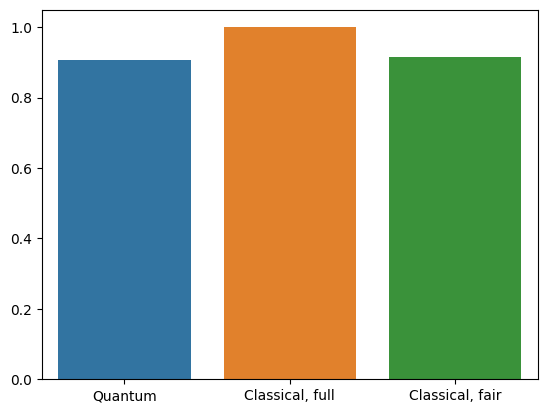

In [36]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, full", "Classical, fair"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy])